# The Goal of this Project
In this project, the goal is to write a software pipeline to identify the lane boundaries in a video from a front-facing camera on a car. 

## Camera Caliberation

In [93]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

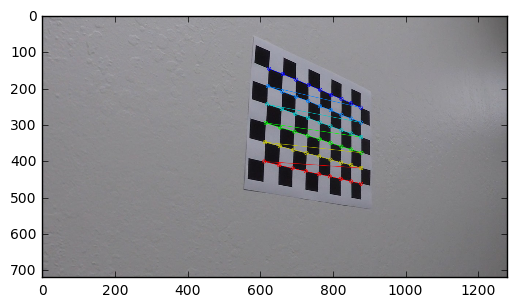

In [94]:
# read in caliberation images
images = glob.glob('camera_cal/calibration*.jpg')

obj_points = []
img_points = []
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    ret, corners = cv2.findChessboardCorners(gray,(9,6),None)

    if ret == True:
        img_points.append(corners)
        obj_points.append(objp)

        img = cv2.drawChessboardCorners(img,(9,6),corners,ret)
        plt.imshow(img)

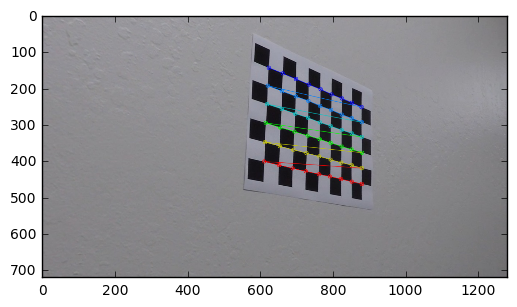

In [95]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, gray.shape[::-1], None, None)
dst = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(dst)
plt.savefig('output_images/chessboard_undistort.jpg')

In [96]:
# threshholding
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    grad_binary = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F,0,1,ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    magxy = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_magxy = np.uint8(255*magxy/np.max(magxy))
    # 5) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled_magxy)
    # 6) Return this mask as your binary_output image
    mag_binary[(scaled_magxy >= mag_thresh[0]) & (scaled_magxy <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F,1,0,ksize=sobel_kernel))
    sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F,0,1,ksize=sobel_kernel))
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    dir_gradient = np.arctan2(sobely, sobelx)
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(dir_gradient)
    # 6) Return this mask as your binary_output image
    dir_binary[(dir_gradient > thresh[0]) & (dir_gradient < thresh[1])] = 1
    return dir_binary

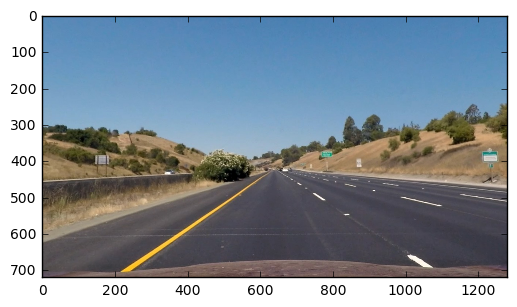

In [97]:
# apply to test images
img = mpimg.imread('test_images/straight_lines1.jpg')

# undistort
def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)
# print distortion-corrected image
dst = undistort(img)
plt.imshow(dst)
plt.savefig('output_images/undistort.jpg')

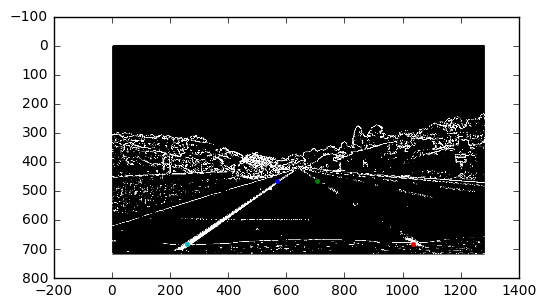

In [98]:
def apply_gradient_threshold(dst):
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(dst, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(dst, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(dst, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(dst, sobel_kernel=ksize, thresh=(0, np.pi/2))
    # apply thresholds
    sxbinary = np.zeros_like(gradx)
    sxbinary[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    #plt.imshow(sxbinary)
    # Threshold color channel
    hls = cv2.cvtColor(dst, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # s channel and gradient
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

combined_binary = apply_gradient_threshold(dst)
plt.imshow(combined_binary,cmap='gray')
plt.savefig('output_images/combined_binary.jpg')
# select four points
plt.plot(567, 465, '.')
plt.plot(567+140, 465,'.')
plt.plot(1035, 682,'.')
plt.plot(260, 682,'.')

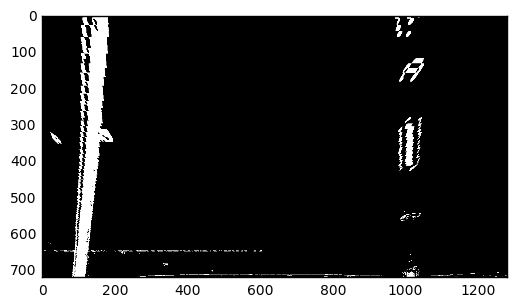

In [158]:
def warp(img):
    img_size = (img.shape[1], img.shape[0])
    
    # source points
    src = np.float32(
        [[567,465],
         [567+140,465],
         [1035,682],
         [260,682]]
        )
    # destination points
    dst = np.float32(
        [[100,0],
         [1000,0],
         [1000,720],
         [100,720]])
    
    # perspective transform
    M = cv2.getPerspectiveTransform(src,dst)
    warped = cv2.warpPerspective(img, M, img_size)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return (warped,M,Minv)

warped, M, Minv = warp(combined_binary)
plt.imshow(warped,cmap='gray')
plt.savefig('output_images/perspective_transform.jpg')

In [159]:
def detect_lane_pixels(warped):
    histogram = np.sum(warped[int(warped.shape[0]/2):,:], axis=0)
    out_img = np.dstack((warped, warped, warped))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped.shape[0] - (window+1)*window_height
        win_y_high = warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    # fit a polynomial
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return (left_fit, right_fit)

In [160]:
def find_lane_pixels_from_last_frame(warped,left_fit, right_fit):
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin))) 
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit

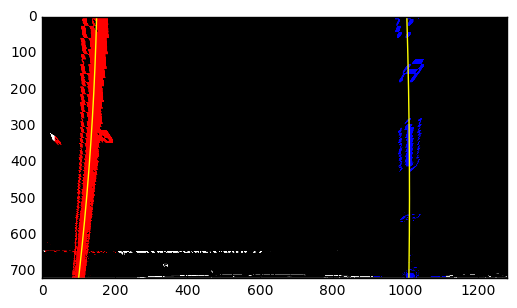

In [161]:
# Generate x and y values for plotting
left_fit,right_fit = detect_lane_pixels(warped)
nonzero = warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin))) 
out_img = np.dstack((warped, warped, warped))*255
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.savefig('output_images/detect_lanes.jpg')

In [166]:
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 
def calculate_curvature(left_fit, right_fit):
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return left_curverad, right_curverad

def calculate_offset(warped,left_fit, right_fit):
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
    y_eval = np.max(ploty)
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # calculate center of lane
    left_bottomx = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    right_bottomx = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    center_of_lane = (left_bottomx + right_bottomx) / 2.0
    # difference between center of lane and middle of frame
    pixel_offset = center_of_lane - warped.shape[1]/2
    real_offset = pixel_offset * xm_per_pix
    return real_offset

def draw_lanes(warped, undist, Minv, left_fit, right_fit):
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    
    left_curve, right_curve = calculate_curvature(left_fit, right_fit)
    offset = calculate_offset(warped,left_fit, right_fit)
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    curvature_text = 'left curve: %.f m, right curve: %.f m' % (left_curve, right_curve)
    img = Image.fromarray(result)
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype("/Library/Fonts/Arial.ttf", 35)
    draw.text((100, 50),curvature_text,(0,0,0),font=font)
    draw.text((100, 100),'offset: %.2f m' % offset,(0,0,0),font=font)
    return np.array(img)

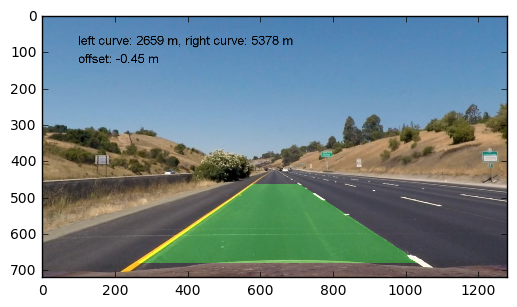

In [167]:
result = draw_lanes(warped,dst,Minv,left_fit,right_fit)
plt.imshow(result)
plt.savefig('output_images/lanes_painted.jpg')

In [146]:
# put together pipeline
def process_image(image):
    undistorted = undistort(image)
    binary = apply_gradient_threshold(undistorted)
    #return binary
    warped, M, Minv = warp(binary)
    #return warped
    left_fit, right_fit = detect_lane_pixels(warped)
    output = draw_lanes(warped, undistorted, Minv, left_fit, right_fit)
    return output

## test on test images

781.072384188
320.060050599
valid


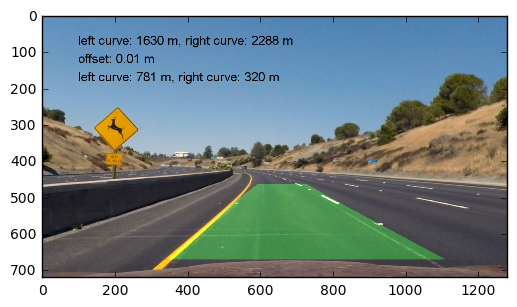

In [157]:
import glob
img = mpimg.imread('test_images/test2.jpg')
output = process_image(img)
plt.imshow(output)

## Test on videos

In [108]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [149]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False 
        # x values of the last n fits of the line
        self.recent_xfitted = []
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        #polynomial coefficients for the most recent fit
        self.current_fit = None
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        self.recent_fits = None

In [168]:
# insert sanity checks and smoothing into pipeline
left = Line()
right = Line()
def process_image(image):
    undistorted = undistort(image)
    binary = apply_gradient_threshold(undistorted)
    warped, M, Minv = warp(binary)
    # find left and right lanes using window search if no previous frame, else margin search
    #if left.current_fit != None:
        #left_fit, right_fit = find_lane_pixels_from_last_frame(warped,left.current_fit, right.current_fit)
    #else:
    left_fit, right_fit = detect_lane_pixels(warped)
    left_curverad, right_curverad = calculate_curvature(left_fit, right_fit)
    print(left_curverad)
    print(right_curverad)
    if (left_curverad < 300 or right_curverad < 300): 
        # too small - bad detection
        next
    elif (abs(left_curverad - right_curverad) < 600) or ((left_curverad > 3000) and (right_curverad > 3000)):
        # either valid curves or straight - save current fit
        print('valid')
        left.current_fit = left_fit
        right.current_fit = right_fit
        if left.recent_fits == None:
            left.recent_fits = left_fit.reshape([1,3])
            right.recent_fits = right_fit.reshape([1,3])
        else:
            left.recent_fits = np.append(left.recent_fits,left_fit.reshape([1,3]),axis=0)
            right.recent_fits = np.append(right.recent_fits,right_fit.reshape([1,3]),axis=0)
        # only keep the 5 most recent fits
        left.recent_fits = left.recent_fits[-5:,:]
        right.recent_fits = right.recent_fits[-5:,:]
    left_fit = np.mean(left.recent_fits,axis=0)
    right_fit = np.mean(right.recent_fits,axis=0)
    output = draw_lanes(warped, undistorted, Minv, left_fit, right_fit)
    return output

In [169]:
output = 'lanes.mp4'
clip = VideoFileClip('project_video.mp4', audio=False)
clip_w_lanes = clip.fl_image(process_image)
%time clip_w_lanes.write_videofile(output, audio=False)

823.976730504
403.200032778
valid
[MoviePy] >>>> Building video lanes.mp4
[MoviePy] Writing video lanes.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<08:00,  2.62it/s]

823.976730504
403.200032778
valid




  0%|          | 2/1261 [00:00<07:52,  2.67it/s]

740.33838754
428.194123579
valid




  0%|          | 3/1261 [00:01<07:40,  2.73it/s]

716.204711284
574.681459959
valid




  0%|          | 4/1261 [00:01<07:29,  2.79it/s]

660.894079328
712.499797184
valid




  0%|          | 5/1261 [00:01<07:17,  2.87it/s]

663.129566414
738.496444366
valid




  0%|          | 6/1261 [00:02<07:16,  2.88it/s]

687.760183895
650.629104612
valid




  1%|          | 7/1261 [00:02<07:10,  2.91it/s]

722.324330865
532.029227354
valid




  1%|          | 8/1261 [00:02<07:07,  2.93it/s]

715.979829789
390.087050931
valid




  1%|          | 9/1261 [00:03<07:02,  2.97it/s]

773.641424054
341.623098987
valid




  1%|          | 10/1261 [00:03<07:03,  2.95it/s]

805.738918636
370.559567003
valid




  1%|          | 11/1261 [00:03<07:03,  2.95it/s]

786.589955568
391.211308143
valid




  1%|          | 12/1261 [00:04<07:01,  2.97it/s]

713.850466009
448.543984222
valid




  1%|          | 13/1261 [00:04<07:03,  2.95it/s]

762.148384834
457.014042993
valid




  1%|          | 14/1261 [00:04<07:01,  2.96it/s]

860.077682483
520.960120648
valid




  1%|          | 15/1261 [00:05<06:56,  2.99it/s]

877.64043208
572.838406822
valid




  1%|▏         | 16/1261 [00:05<06:55,  3.00it/s]

923.895184397
894.769341342
valid




  1%|▏         | 17/1261 [00:05<06:52,  3.01it/s]

953.399855501
1331.64806546
valid




  1%|▏         | 18/1261 [00:06<06:48,  3.05it/s]

913.304723798
1534.82680575




  2%|▏         | 19/1261 [00:06<06:46,  3.06it/s]

1025.61581625
742.552000132
valid




  2%|▏         | 20/1261 [00:06<06:47,  3.05it/s]

1135.96158523
523.042981015




  2%|▏         | 21/1261 [00:07<06:48,  3.04it/s]

1155.94411271
406.491253515




  2%|▏         | 22/1261 [00:07<06:52,  3.01it/s]

1323.31735699
375.816140237




  2%|▏         | 23/1261 [00:07<06:49,  3.03it/s]

1557.67328
349.712963454




  2%|▏         | 24/1261 [00:08<06:47,  3.03it/s]

1221.96148458
390.079033727




  2%|▏         | 25/1261 [00:08<06:49,  3.02it/s]

1128.11268164
409.247927902




  2%|▏         | 26/1261 [00:08<06:48,  3.03it/s]

1078.19597366
431.020874667




  2%|▏         | 27/1261 [00:09<06:46,  3.04it/s]

1008.95440087
496.639759028
valid




  2%|▏         | 28/1261 [00:09<06:47,  3.03it/s]

896.58510545
558.890243621
valid




  2%|▏         | 29/1261 [00:09<06:46,  3.03it/s]

868.056289064
598.779267498
valid




  2%|▏         | 30/1261 [00:10<06:45,  3.03it/s]

859.204360997
727.947427784
valid




  2%|▏         | 31/1261 [00:10<06:48,  3.01it/s]

871.028883989
851.467238426
valid




  3%|▎         | 32/1261 [00:10<06:47,  3.01it/s]

795.570043017
552.569903656
valid




  3%|▎         | 33/1261 [00:11<06:47,  3.02it/s]

780.567577805
370.39190282
valid




  3%|▎         | 34/1261 [00:11<06:43,  3.04it/s]

804.999256653
361.188050672
valid




  3%|▎         | 35/1261 [00:11<06:43,  3.04it/s]

789.084828771
363.840925077
valid




  3%|▎         | 36/1261 [00:12<06:39,  3.07it/s]

793.62770246
384.693323035
valid




  3%|▎         | 37/1261 [00:12<06:37,  3.08it/s]

754.607673014
427.896840999
valid




  3%|▎         | 38/1261 [00:12<06:37,  3.08it/s]

743.211028955
443.883699036
valid




  3%|▎         | 39/1261 [00:12<06:37,  3.08it/s]

704.531113434
420.947875915
valid




  3%|▎         | 40/1261 [00:13<06:36,  3.08it/s]

690.134324408
448.982430864
valid




  3%|▎         | 41/1261 [00:13<06:36,  3.07it/s]

693.168358529
513.614161669
valid




  3%|▎         | 42/1261 [00:13<06:36,  3.07it/s]

678.609777184
782.392380064
valid




  3%|▎         | 43/1261 [00:14<06:45,  3.00it/s]

687.464952527
696.697189795
valid




  3%|▎         | 44/1261 [00:14<06:44,  3.01it/s]

717.607465396
760.281035374
valid




  4%|▎         | 45/1261 [00:14<06:40,  3.03it/s]

679.886042783
509.133303708
valid




  4%|▎         | 46/1261 [00:15<06:42,  3.02it/s]

661.019444976
404.171623168
valid




  4%|▎         | 47/1261 [00:15<06:43,  3.01it/s]

717.065798635
351.169246938
valid




  4%|▍         | 48/1261 [00:15<06:48,  2.97it/s]

709.814762705
337.809879856
valid




  4%|▍         | 49/1261 [00:16<06:48,  2.97it/s]

695.997543871
377.805837952
valid




  4%|▍         | 50/1261 [00:16<06:52,  2.94it/s]

693.628283941
409.120951745
valid




  4%|▍         | 51/1261 [00:17<06:51,  2.94it/s]

754.33936292
423.402272022
valid




  4%|▍         | 52/1261 [00:17<07:00,  2.87it/s]

731.000246047
460.341864375
valid




  4%|▍         | 53/1261 [00:17<06:57,  2.89it/s]

765.687655964
413.164004115
valid




  4%|▍         | 54/1261 [00:18<06:58,  2.89it/s]

781.273689607
561.942482461
valid




  4%|▍         | 55/1261 [00:18<07:01,  2.86it/s]

893.122149956
842.242064214
valid




  4%|▍         | 56/1261 [00:18<06:56,  2.89it/s]

959.399361997
903.31521412
valid




  5%|▍         | 57/1261 [00:19<06:51,  2.93it/s]

1033.04588641
989.55572108
valid




  5%|▍         | 58/1261 [00:19<06:49,  2.94it/s]

1084.02406857
418.950887847




  5%|▍         | 59/1261 [00:19<06:52,  2.92it/s]

1169.58730483
409.957392345




  5%|▍         | 60/1261 [00:20<06:50,  2.93it/s]

1149.73962121
394.474122738




  5%|▍         | 61/1261 [00:20<06:50,  2.92it/s]

1104.10711719
426.417652893




  5%|▍         | 62/1261 [00:20<06:50,  2.92it/s]

979.476750493
600.026346549
valid




  5%|▍         | 63/1261 [00:21<06:53,  2.89it/s]

981.37184726
355.476747362




  5%|▌         | 64/1261 [00:21<06:53,  2.90it/s]

959.594417046
450.278961533
valid




  5%|▌         | 65/1261 [00:21<06:52,  2.90it/s]

815.02470744
456.759857879
valid




  5%|▌         | 66/1261 [00:22<06:48,  2.93it/s]

780.332252073
561.793259906
valid




  5%|▌         | 67/1261 [00:22<06:43,  2.96it/s]

704.679430078
680.846220787
valid




  5%|▌         | 68/1261 [00:22<06:44,  2.95it/s]

692.624802677
2019.96780535




  5%|▌         | 69/1261 [00:23<06:41,  2.97it/s]

677.977575085
653.133793188
valid




  6%|▌         | 70/1261 [00:23<06:43,  2.95it/s]

655.146356216
865.249945898
valid




  6%|▌         | 71/1261 [00:23<06:43,  2.95it/s]

695.138566829
505.798960865
valid




  6%|▌         | 72/1261 [00:24<06:41,  2.96it/s]

710.596965616
432.118409203
valid




  6%|▌         | 73/1261 [00:24<06:44,  2.94it/s]

754.246504579
408.996569818
valid




  6%|▌         | 74/1261 [00:24<06:46,  2.92it/s]

815.999353685
451.691754797
valid




  6%|▌         | 75/1261 [00:25<06:46,  2.92it/s]

849.938535558
465.793783297
valid




  6%|▌         | 76/1261 [00:25<06:43,  2.94it/s]

916.113841499
428.255358557
valid




  6%|▌         | 77/1261 [00:25<06:46,  2.91it/s]

991.158245908
405.8499743
valid




  6%|▌         | 78/1261 [00:26<06:43,  2.93it/s]

1004.30217561
457.427625191
valid




  6%|▋         | 79/1261 [00:26<06:45,  2.91it/s]

1034.18226687
539.593145885
valid




  6%|▋         | 80/1261 [00:26<06:43,  2.93it/s]

1091.36780663
552.843401147
valid




  6%|▋         | 81/1261 [00:27<06:44,  2.92it/s]

1162.11557973
714.102993938
valid




  7%|▋         | 82/1261 [00:27<06:40,  2.95it/s]

1083.86689564
614.366416044
valid




  7%|▋         | 83/1261 [00:27<06:37,  2.96it/s]

1064.76790459
477.793938669
valid




  7%|▋         | 84/1261 [00:28<06:35,  2.97it/s]

1073.63808499
416.378938104




  7%|▋         | 85/1261 [00:28<06:36,  2.97it/s]

1013.68481155
403.445640816




  7%|▋         | 86/1261 [00:28<06:35,  2.97it/s]

900.478322206
403.311145678
valid




  7%|▋         | 87/1261 [00:29<06:39,  2.94it/s]

835.476072818
450.677091969
valid




  7%|▋         | 88/1261 [00:29<06:44,  2.90it/s]

760.12007951
549.43464678
valid




  7%|▋         | 89/1261 [00:30<06:42,  2.91it/s]

740.219290477
390.559671862
valid




  7%|▋         | 90/1261 [00:30<06:43,  2.90it/s]

664.830884025
423.527227604
valid




  7%|▋         | 91/1261 [00:30<06:40,  2.92it/s]

663.041414359
466.761986197
valid




  7%|▋         | 92/1261 [00:31<06:43,  2.90it/s]

654.749016024
807.898810163
valid




  7%|▋         | 93/1261 [00:31<06:47,  2.86it/s]

672.489422356
898.74279435
valid




  7%|▋         | 94/1261 [00:31<06:46,  2.87it/s]

679.798557902
952.841614347
valid




  8%|▊         | 95/1261 [00:32<06:44,  2.88it/s]

673.760726267
883.387414227
valid




  8%|▊         | 96/1261 [00:32<06:40,  2.91it/s]

668.368207685
636.499698054
valid




  8%|▊         | 97/1261 [00:32<06:52,  2.82it/s]

679.157886917
434.689853656
valid




  8%|▊         | 98/1261 [00:33<06:47,  2.85it/s]

693.979358789
451.296684503
valid




  8%|▊         | 99/1261 [00:33<06:42,  2.89it/s]

712.640337936
427.301249844
valid




  8%|▊         | 100/1261 [00:33<06:38,  2.91it/s]

716.237965992
466.734520759
valid




  8%|▊         | 101/1261 [00:34<06:37,  2.92it/s]

726.839928914
519.616306989
valid




  8%|▊         | 102/1261 [00:34<06:37,  2.92it/s]

728.063519069
520.291904486
valid




  8%|▊         | 103/1261 [00:34<06:34,  2.93it/s]

706.453984682
395.885638143
valid




  8%|▊         | 104/1261 [00:35<06:32,  2.95it/s]

729.484527922
412.022580776
valid




  8%|▊         | 105/1261 [00:35<06:33,  2.94it/s]

770.202402427
616.396108795
valid




  8%|▊         | 106/1261 [00:35<06:30,  2.96it/s]

790.496602999
726.907831921
valid




  8%|▊         | 107/1261 [00:36<06:28,  2.97it/s]

799.793679672
712.782636072
valid




  9%|▊         | 108/1261 [00:36<06:27,  2.98it/s]

778.402580771
539.659871618
valid




  9%|▊         | 109/1261 [00:36<06:26,  2.98it/s]

766.076427827
463.038226644
valid




  9%|▊         | 110/1261 [00:37<06:22,  3.01it/s]

851.075600895
388.679225977
valid




  9%|▉         | 111/1261 [00:37<06:26,  2.98it/s]

760.133160287
400.40614281
valid




  9%|▉         | 112/1261 [00:37<06:25,  2.98it/s]

749.379194353
393.332690744
valid




  9%|▉         | 113/1261 [00:38<06:28,  2.96it/s]

726.944446867
387.501695264
valid




  9%|▉         | 114/1261 [00:38<06:27,  2.96it/s]

699.237388035
421.655535046
valid




  9%|▉         | 115/1261 [00:38<06:25,  2.97it/s]

677.111927103
395.19463013
valid




  9%|▉         | 116/1261 [00:39<06:23,  2.98it/s]

676.31773139
420.796979875
valid




  9%|▉         | 117/1261 [00:39<06:24,  2.97it/s]

673.466504948
530.022812323
valid




  9%|▉         | 118/1261 [00:39<06:24,  2.98it/s]

673.64601507
619.366597999
valid




  9%|▉         | 119/1261 [00:40<06:22,  2.99it/s]

671.658882901
561.140821178
valid




 10%|▉         | 120/1261 [00:40<06:23,  2.98it/s]

653.130201719
531.61937208
valid




 10%|▉         | 121/1261 [00:40<06:24,  2.97it/s]

672.012008886
419.044361986
valid




 10%|▉         | 122/1261 [00:41<06:32,  2.90it/s]

675.144255126
354.91173296
valid




 10%|▉         | 123/1261 [00:41<06:28,  2.93it/s]

672.590621506
372.167838223
valid




 10%|▉         | 124/1261 [00:41<06:23,  2.97it/s]

672.726558769
436.214737742
valid




 10%|▉         | 125/1261 [00:42<06:22,  2.97it/s]

674.35878062
477.858740349
valid




 10%|▉         | 126/1261 [00:42<06:23,  2.96it/s]

674.873266215
457.123381801
valid




 10%|█         | 127/1261 [00:42<06:19,  2.99it/s]

702.688185263
454.292361686
valid




 10%|█         | 128/1261 [00:43<06:17,  3.00it/s]

687.018020711
460.917038556
valid




 10%|█         | 129/1261 [00:43<06:16,  3.01it/s]

690.725775141
552.363600288
valid




 10%|█         | 130/1261 [00:43<06:17,  2.99it/s]

707.294072986
747.887536983
valid




 10%|█         | 131/1261 [00:44<06:18,  2.99it/s]

691.109585996
754.976038976
valid




 10%|█         | 132/1261 [00:44<06:18,  2.99it/s]

707.696844516
602.694373367
valid




 11%|█         | 133/1261 [00:44<06:17,  2.99it/s]

722.167596727
584.331824466
valid




 11%|█         | 134/1261 [00:45<06:17,  2.99it/s]

765.765816235
394.977252369
valid




 11%|█         | 135/1261 [00:45<06:19,  2.97it/s]

782.817266798
363.732926207
valid




 11%|█         | 136/1261 [00:45<06:17,  2.98it/s]

821.868427506
382.127559137
valid




 11%|█         | 137/1261 [00:46<06:18,  2.97it/s]

826.230801765
410.302197056
valid




 11%|█         | 138/1261 [00:46<06:16,  2.98it/s]

870.704563116
412.601427104
valid




 11%|█         | 139/1261 [00:46<06:15,  2.99it/s]

858.784588201
436.688060945
valid




 11%|█         | 140/1261 [00:47<06:14,  2.99it/s]

879.624766439
415.479337738
valid




 11%|█         | 141/1261 [00:47<06:17,  2.97it/s]

838.209765111
484.364784221
valid




 11%|█▏        | 142/1261 [00:47<06:17,  2.96it/s]

808.626465236
719.844283884
valid




 11%|█▏        | 143/1261 [00:48<06:16,  2.97it/s]

814.362215897
902.228151345
valid




 11%|█▏        | 144/1261 [00:48<06:16,  2.96it/s]

804.744513259
716.954094923
valid




 11%|█▏        | 145/1261 [00:48<06:12,  2.99it/s]

788.157064116
716.347215409
valid




 12%|█▏        | 146/1261 [00:49<06:13,  2.98it/s]

809.601496431
425.203077261
valid




 12%|█▏        | 147/1261 [00:49<06:14,  2.98it/s]

821.330043585
376.632469063
valid




 12%|█▏        | 148/1261 [00:49<06:13,  2.98it/s]

876.016495968
407.704264291
valid




 12%|█▏        | 149/1261 [00:50<06:10,  3.00it/s]

874.197797246
456.493593729
valid




 12%|█▏        | 150/1261 [00:50<06:13,  2.97it/s]

902.769466959
458.579691126
valid




 12%|█▏        | 151/1261 [00:50<06:12,  2.98it/s]

943.949332304
403.377963388
valid




 12%|█▏        | 152/1261 [00:51<06:24,  2.89it/s]

910.193862717
422.441943847
valid




 12%|█▏        | 153/1261 [00:51<06:22,  2.90it/s]

875.773630543
438.744804585
valid




 12%|█▏        | 154/1261 [00:52<06:19,  2.91it/s]

888.609380981
559.131943369
valid




 12%|█▏        | 155/1261 [00:52<06:19,  2.92it/s]

940.461856803
661.531279494
valid




 12%|█▏        | 156/1261 [00:52<06:18,  2.92it/s]

945.629459013
645.880337746
valid




 12%|█▏        | 157/1261 [00:53<06:16,  2.93it/s]

917.71466136
531.791247585
valid




 13%|█▎        | 158/1261 [00:53<06:14,  2.94it/s]

810.618210067
515.276598532
valid




 13%|█▎        | 159/1261 [00:53<06:16,  2.93it/s]

881.700504991
378.377498357
valid




 13%|█▎        | 160/1261 [00:54<06:16,  2.92it/s]

839.814654494
391.43219389
valid




 13%|█▎        | 161/1261 [00:54<06:24,  2.86it/s]

824.271695159
399.377331759
valid




 13%|█▎        | 162/1261 [00:54<06:23,  2.87it/s]

782.378623743
447.141603496
valid




 13%|█▎        | 163/1261 [00:55<06:22,  2.87it/s]

776.654051645
456.125741032
valid




 13%|█▎        | 164/1261 [00:55<06:23,  2.86it/s]

791.260542911
454.197393581
valid




 13%|█▎        | 165/1261 [00:55<06:20,  2.88it/s]

749.765530346
475.894005478
valid




 13%|█▎        | 166/1261 [00:56<06:20,  2.88it/s]

726.827815274
592.302383055
valid




 13%|█▎        | 167/1261 [00:56<06:40,  2.73it/s]

807.960735808
731.637674943
valid




 13%|█▎        | 168/1261 [00:56<06:36,  2.76it/s]

736.472306661
915.512310876
valid




 13%|█▎        | 169/1261 [00:57<06:31,  2.79it/s]

706.97521658
757.807830668
valid




 13%|█▎        | 170/1261 [00:57<06:23,  2.85it/s]

770.818303498
718.934606173
valid




 14%|█▎        | 171/1261 [00:57<06:17,  2.89it/s]

711.305103104
465.533065439
valid




 14%|█▎        | 172/1261 [00:58<06:14,  2.91it/s]

750.113471019
410.588051986
valid




 14%|█▎        | 173/1261 [00:58<06:13,  2.92it/s]

802.645758424
396.319220516
valid




 14%|█▍        | 174/1261 [00:58<06:09,  2.95it/s]

878.067707949
431.177653104
valid




 14%|█▍        | 175/1261 [00:59<06:11,  2.92it/s]

973.283456726
493.781042356
valid




 14%|█▍        | 176/1261 [00:59<06:10,  2.93it/s]

974.491866257
439.052005394
valid




 14%|█▍        | 177/1261 [01:00<06:11,  2.92it/s]

900.341443004
335.017400772
valid




 14%|█▍        | 178/1261 [01:00<06:11,  2.91it/s]

870.737392065
382.533615413
valid




 14%|█▍        | 179/1261 [01:00<06:11,  2.91it/s]

909.527798221
538.21805975
valid




 14%|█▍        | 180/1261 [01:01<06:07,  2.94it/s]

885.590224841
611.413994857
valid




 14%|█▍        | 181/1261 [01:01<06:08,  2.93it/s]

781.54342564
614.099696285
valid




 14%|█▍        | 182/1261 [01:01<06:07,  2.94it/s]

761.388256469
531.319975365
valid




 15%|█▍        | 183/1261 [01:02<06:05,  2.95it/s]

686.950715382
414.512474279
valid




 15%|█▍        | 184/1261 [01:02<06:02,  2.97it/s]

640.620227989
330.749759245
valid




 15%|█▍        | 185/1261 [01:02<06:02,  2.97it/s]

605.286355514
423.864417953
valid




 15%|█▍        | 186/1261 [01:03<06:01,  2.97it/s]

596.320168585
603.025848425
valid




 15%|█▍        | 187/1261 [01:03<05:59,  2.99it/s]

568.830415067
530.434635617
valid




 15%|█▍        | 188/1261 [01:03<05:57,  3.00it/s]

588.855303811
645.666018974
valid




 15%|█▍        | 189/1261 [01:04<05:58,  2.99it/s]

590.186952946
897.202974287
valid




 15%|█▌        | 190/1261 [01:04<06:01,  2.96it/s]

620.487750306
562.265761834
valid




 15%|█▌        | 191/1261 [01:04<06:01,  2.96it/s]

613.227446124
1291.10517787




 15%|█▌        | 192/1261 [01:05<05:59,  2.97it/s]

618.318581246
1896.41032979




 15%|█▌        | 193/1261 [01:05<05:58,  2.98it/s]

609.24604754
683.691385651
valid




 15%|█▌        | 194/1261 [01:05<05:56,  2.99it/s]

655.925180289
1396.22553128




 15%|█▌        | 195/1261 [01:06<05:55,  3.00it/s]

636.059327873
1006.0627015
valid




 16%|█▌        | 196/1261 [01:06<05:53,  3.01it/s]

701.823705571
490.907815763
valid




 16%|█▌        | 197/1261 [01:06<05:55,  2.99it/s]

712.242126602
363.568235836
valid




 16%|█▌        | 198/1261 [01:07<05:58,  2.97it/s]

746.804293172
353.600231149
valid




 16%|█▌        | 199/1261 [01:07<05:56,  2.98it/s]

776.874612089
357.428410071
valid




 16%|█▌        | 200/1261 [01:07<05:55,  2.98it/s]

731.262253797
382.884222829
valid




 16%|█▌        | 201/1261 [01:08<05:54,  2.99it/s]

761.542276029
406.145318624
valid




 16%|█▌        | 202/1261 [01:08<05:52,  3.00it/s]

712.670974763
486.526210147
valid




 16%|█▌        | 203/1261 [01:08<05:51,  3.01it/s]

721.614163267
493.107366429
valid




 16%|█▌        | 204/1261 [01:09<05:51,  3.00it/s]

749.010225532
569.731321806
valid




 16%|█▋        | 205/1261 [01:09<05:51,  3.01it/s]

774.968140045
885.355782512
valid




 16%|█▋        | 206/1261 [01:09<05:52,  2.99it/s]

770.949291756
865.721784145
valid




 16%|█▋        | 207/1261 [01:10<05:51,  3.00it/s]

788.62256524
703.710146453
valid




 16%|█▋        | 208/1261 [01:10<06:04,  2.89it/s]

735.865575909
602.023118176
valid




 17%|█▋        | 209/1261 [01:10<06:09,  2.85it/s]

747.054159844
434.637817855
valid




 17%|█▋        | 210/1261 [01:11<06:14,  2.81it/s]

730.508510641
373.910737904
valid




 17%|█▋        | 211/1261 [01:11<06:36,  2.65it/s]

744.463808541
384.531914502
valid




 17%|█▋        | 212/1261 [01:11<06:21,  2.75it/s]

714.775643102
428.965093301
valid




 17%|█▋        | 213/1261 [01:12<06:27,  2.71it/s]

681.011635019
497.607649844
valid




 17%|█▋        | 214/1261 [01:12<06:21,  2.74it/s]

634.659710983
435.337790853
valid




 17%|█▋        | 215/1261 [01:13<06:16,  2.78it/s]

610.075218193
503.624334858
valid




 17%|█▋        | 216/1261 [01:13<06:08,  2.83it/s]

672.320335135
600.46185411
valid




 17%|█▋        | 217/1261 [01:13<06:03,  2.87it/s]

630.691016334
730.301140428
valid




 17%|█▋        | 218/1261 [01:14<05:57,  2.92it/s]

655.39770873
1340.05635627




 17%|█▋        | 219/1261 [01:14<05:55,  2.93it/s]

625.103962783
1107.5421301
valid




 17%|█▋        | 220/1261 [01:14<05:51,  2.96it/s]

648.853970178
871.421389794
valid




 18%|█▊        | 221/1261 [01:15<05:52,  2.95it/s]

669.107871385
719.744018285
valid




 18%|█▊        | 222/1261 [01:15<05:50,  2.96it/s]

680.777336835
466.264271099
valid




 18%|█▊        | 223/1261 [01:15<05:52,  2.95it/s]

729.895618719
400.967999617
valid




 18%|█▊        | 224/1261 [01:16<05:54,  2.93it/s]

720.94037228
428.049456485
valid




 18%|█▊        | 225/1261 [01:16<05:53,  2.93it/s]

713.743639966
563.147563138
valid




 18%|█▊        | 226/1261 [01:16<05:52,  2.93it/s]

687.941225086
346.256814573
valid




 18%|█▊        | 227/1261 [01:17<05:50,  2.95it/s]

661.96113373
747.762231318
valid




 18%|█▊        | 228/1261 [01:17<05:47,  2.97it/s]

716.385004794
632.551477792
valid




 18%|█▊        | 229/1261 [01:17<05:46,  2.98it/s]

728.029989043
830.587516923
valid




 18%|█▊        | 230/1261 [01:18<05:45,  2.99it/s]

773.54667766
1071.01806529
valid




 18%|█▊        | 231/1261 [01:18<05:48,  2.96it/s]

767.866143267
965.290354479
valid




 18%|█▊        | 232/1261 [01:18<05:48,  2.95it/s]

853.457248847
718.54178598
valid




 18%|█▊        | 233/1261 [01:19<05:50,  2.94it/s]

844.518106586
714.807496999
valid




 19%|█▊        | 234/1261 [01:19<05:47,  2.95it/s]

870.702774493
495.082155686
valid




 19%|█▊        | 235/1261 [01:19<05:46,  2.96it/s]

879.919523477
368.386245049
valid




 19%|█▊        | 236/1261 [01:20<05:43,  2.98it/s]

819.21291134
462.668142618
valid




 19%|█▉        | 237/1261 [01:20<05:44,  2.97it/s]

830.935026019
652.127862017
valid




 19%|█▉        | 238/1261 [01:20<05:41,  2.99it/s]

758.750964591
385.835063297
valid




 19%|█▉        | 239/1261 [01:21<05:41,  2.99it/s]

731.97389787
321.247662253
valid




 19%|█▉        | 240/1261 [01:21<05:46,  2.95it/s]

755.103633266
399.71994613
valid




 19%|█▉        | 241/1261 [01:21<05:50,  2.91it/s]

748.671192183
487.644948192
valid




 19%|█▉        | 242/1261 [01:22<05:44,  2.95it/s]

759.543275022
949.087944494
valid




 19%|█▉        | 243/1261 [01:22<05:47,  2.93it/s]

673.666628762
835.558076761
valid




 19%|█▉        | 244/1261 [01:22<05:48,  2.92it/s]

667.702137551
864.307966787
valid




 19%|█▉        | 245/1261 [01:23<05:48,  2.92it/s]

616.335996122
3278.64751701




 20%|█▉        | 246/1261 [01:23<05:47,  2.92it/s]

590.517142608
1295.5426552




 20%|█▉        | 247/1261 [01:23<05:48,  2.91it/s]

581.054571328
655.664015544
valid




 20%|█▉        | 248/1261 [01:24<05:43,  2.95it/s]

569.350696279
615.98657019
valid




 20%|█▉        | 249/1261 [01:24<05:43,  2.95it/s]

550.193627699
627.577269324
valid




 20%|█▉        | 250/1261 [01:24<05:43,  2.95it/s]

547.819146958
370.18267668
valid




 20%|█▉        | 251/1261 [01:25<05:41,  2.96it/s]

534.096824816
293.594305586




 20%|█▉        | 252/1261 [01:25<05:43,  2.94it/s]

562.611703608
387.791784824
valid




 20%|██        | 253/1261 [01:25<05:44,  2.93it/s]

564.267667117
465.07593673
valid




 20%|██        | 254/1261 [01:26<05:42,  2.94it/s]

571.721552409
778.5792856
valid




 20%|██        | 255/1261 [01:26<05:48,  2.89it/s]

573.714521362
634.183343677
valid




 20%|██        | 256/1261 [01:26<05:44,  2.92it/s]

598.688636425
652.044468354
valid




 20%|██        | 257/1261 [01:27<05:45,  2.91it/s]

607.858953982
773.297051881
valid




 20%|██        | 258/1261 [01:27<05:44,  2.91it/s]

605.857488959
491.339873451
valid




 21%|██        | 259/1261 [01:27<05:43,  2.91it/s]

660.054618636
591.433194899
valid




 21%|██        | 260/1261 [01:28<05:40,  2.94it/s]

675.463984802
652.014832522
valid




 21%|██        | 261/1261 [01:28<05:41,  2.93it/s]

677.570185282
596.687777031
valid




 21%|██        | 262/1261 [01:28<05:38,  2.95it/s]

680.159822762
353.298823016
valid




 21%|██        | 263/1261 [01:29<05:40,  2.93it/s]

665.309227947
452.880995734
valid




 21%|██        | 264/1261 [01:29<06:01,  2.76it/s]

649.469083661
459.89634536
valid




 21%|██        | 265/1261 [01:30<06:19,  2.62it/s]

647.868390839
580.319544297
valid




 21%|██        | 266/1261 [01:30<06:17,  2.63it/s]

655.076459048
731.537844484
valid




 21%|██        | 267/1261 [01:30<06:11,  2.67it/s]

654.971021858
488.235465369
valid




 21%|██▏       | 268/1261 [01:31<06:00,  2.75it/s]

649.123536903
493.239925265
valid




 21%|██▏       | 269/1261 [01:31<05:57,  2.78it/s]

627.021242191
479.328744021
valid




 21%|██▏       | 270/1261 [01:31<06:00,  2.75it/s]

621.106627264
448.844731667
valid




 21%|██▏       | 271/1261 [01:32<06:04,  2.72it/s]

652.451632727
412.660606533
valid




 22%|██▏       | 272/1261 [01:32<05:55,  2.78it/s]

665.681795883
531.690606794
valid




 22%|██▏       | 273/1261 [01:33<05:52,  2.80it/s]

649.760132661
531.690695538
valid




 22%|██▏       | 274/1261 [01:33<05:45,  2.85it/s]

675.142686571
333.68892435
valid




 22%|██▏       | 275/1261 [01:33<06:04,  2.71it/s]

679.276319357
488.802901994
valid




 22%|██▏       | 276/1261 [01:34<05:54,  2.78it/s]

684.764209214
480.432959348
valid




 22%|██▏       | 277/1261 [01:34<05:52,  2.79it/s]

700.334979234
630.943569955
valid




 22%|██▏       | 278/1261 [01:34<05:52,  2.79it/s]

716.76808855
784.136757669
valid




 22%|██▏       | 279/1261 [01:35<05:47,  2.82it/s]

712.561202591
665.923627974
valid




 22%|██▏       | 280/1261 [01:35<05:41,  2.87it/s]

726.217402026
604.377072327
valid




 22%|██▏       | 281/1261 [01:35<05:40,  2.88it/s]

748.003868631
497.199138616
valid




 22%|██▏       | 282/1261 [01:36<05:36,  2.91it/s]

740.269970743
456.945625533
valid




 22%|██▏       | 283/1261 [01:36<05:35,  2.92it/s]

753.623609961
459.690283296
valid




 23%|██▎       | 284/1261 [01:36<05:31,  2.94it/s]

773.193616352
499.781712804
valid




 23%|██▎       | 285/1261 [01:37<05:29,  2.96it/s]

783.165142096
486.275775498
valid




 23%|██▎       | 286/1261 [01:37<05:32,  2.93it/s]

803.274566714
480.217459044
valid




 23%|██▎       | 287/1261 [01:37<05:33,  2.92it/s]

819.479702336
496.614803985
valid




 23%|██▎       | 288/1261 [01:38<05:31,  2.94it/s]

829.763617558
544.240189002
valid




 23%|██▎       | 289/1261 [01:38<05:41,  2.84it/s]

865.202134496
685.038308974
valid




 23%|██▎       | 290/1261 [01:38<05:41,  2.85it/s]

875.545896866
652.467739362
valid




 23%|██▎       | 291/1261 [01:39<05:37,  2.88it/s]

845.22884799
572.524778637
valid




 23%|██▎       | 292/1261 [01:39<05:32,  2.92it/s]

882.427798405
498.534454008
valid




 23%|██▎       | 293/1261 [01:39<05:41,  2.83it/s]

910.738629018
427.234380434
valid




 23%|██▎       | 294/1261 [01:40<05:33,  2.90it/s]

924.528234215
457.663760285
valid




 23%|██▎       | 295/1261 [01:40<05:27,  2.95it/s]

965.359222902
463.538750087
valid




 23%|██▎       | 296/1261 [01:40<05:26,  2.96it/s]

981.440815904
459.765046757
valid




 24%|██▎       | 297/1261 [01:41<05:22,  2.98it/s]

947.477131283
427.699968861
valid




 24%|██▎       | 298/1261 [01:41<05:25,  2.95it/s]

979.222826262
423.805998805
valid




 24%|██▎       | 299/1261 [01:42<05:31,  2.90it/s]

898.533400679
474.687789022
valid




 24%|██▍       | 300/1261 [01:42<05:30,  2.91it/s]

909.779503749
554.320981847
valid




 24%|██▍       | 301/1261 [01:42<05:26,  2.94it/s]

922.838948993
584.40603328
valid




 24%|██▍       | 302/1261 [01:43<05:24,  2.95it/s]

928.64810566
614.948100382
valid




 24%|██▍       | 303/1261 [01:43<05:30,  2.90it/s]

917.943420452
536.438563417
valid




 24%|██▍       | 304/1261 [01:43<05:28,  2.92it/s]

938.127261847
520.706715399
valid




 24%|██▍       | 305/1261 [01:44<05:27,  2.92it/s]

917.261294473
429.154138116
valid




 24%|██▍       | 306/1261 [01:44<05:25,  2.93it/s]

1006.15653119
439.769843948
valid




 24%|██▍       | 307/1261 [01:44<05:26,  2.92it/s]

987.591880982
447.758862958
valid




 24%|██▍       | 308/1261 [01:45<05:20,  2.97it/s]

1102.73611946
461.716998014




 25%|██▍       | 309/1261 [01:45<05:19,  2.98it/s]

1224.46199265
427.424729638




 25%|██▍       | 310/1261 [01:45<05:16,  3.01it/s]

1300.17646808
486.318319403




 25%|██▍       | 311/1261 [01:46<05:16,  3.00it/s]

1211.03852532
601.844047059




 25%|██▍       | 312/1261 [01:46<05:13,  3.02it/s]

1240.65152166
682.228271239
valid




 25%|██▍       | 313/1261 [01:46<05:16,  2.99it/s]

1205.37200765
765.050677161
valid




 25%|██▍       | 314/1261 [01:47<05:23,  2.92it/s]

1215.73241165
773.723839387
valid




 25%|██▍       | 315/1261 [01:47<05:24,  2.91it/s]

1272.96310012
734.008892532
valid




 25%|██▌       | 316/1261 [01:47<05:23,  2.92it/s]

1367.23510196
650.681194205




 25%|██▌       | 317/1261 [01:48<05:21,  2.94it/s]

1297.61408112
519.590574598




 25%|██▌       | 318/1261 [01:48<05:20,  2.95it/s]

1524.98246909
517.236572694




 25%|██▌       | 319/1261 [01:48<05:52,  2.67it/s]

1557.65321077
541.964729494




 25%|██▌       | 320/1261 [01:49<05:51,  2.68it/s]

1523.23590963
461.347682995




 25%|██▌       | 321/1261 [01:49<05:56,  2.64it/s]

1708.03278699
443.71062398




 26%|██▌       | 322/1261 [01:50<05:56,  2.63it/s]

1948.66614694
466.098455272




 26%|██▌       | 323/1261 [01:50<05:48,  2.69it/s]

1814.03841886
518.331946181




 26%|██▌       | 324/1261 [01:50<05:40,  2.75it/s]

1997.47507543
519.025413551




 26%|██▌       | 325/1261 [01:51<05:35,  2.79it/s]

1700.59851766
529.481539514




 26%|██▌       | 326/1261 [01:51<05:27,  2.86it/s]

1665.87360462
527.487605148




 26%|██▌       | 327/1261 [01:51<05:44,  2.71it/s]

1663.07044112
543.764364791




 26%|██▌       | 328/1261 [01:52<05:34,  2.79it/s]

1604.42603499
518.411064478




 26%|██▌       | 329/1261 [01:52<05:30,  2.82it/s]

1689.62512565
429.709981279




 26%|██▌       | 330/1261 [01:52<05:22,  2.88it/s]

1668.96614522
482.550309491




 26%|██▌       | 331/1261 [01:53<05:20,  2.90it/s]

1573.99234609
456.319101012




 26%|██▋       | 332/1261 [01:53<05:18,  2.91it/s]

1406.73909703
433.33796669




 26%|██▋       | 333/1261 [01:53<05:24,  2.86it/s]

1375.24182279
519.015015924




 26%|██▋       | 334/1261 [01:54<05:19,  2.90it/s]

1448.05012197
515.459316594




 27%|██▋       | 335/1261 [01:54<05:21,  2.88it/s]

1356.49339022
485.081772314




 27%|██▋       | 336/1261 [01:54<05:17,  2.91it/s]

1485.27165995
605.889118825




 27%|██▋       | 337/1261 [01:55<05:22,  2.86it/s]

1491.48945214
520.351060669




 27%|██▋       | 338/1261 [01:55<05:18,  2.90it/s]

1315.19073607
535.111091475




 27%|██▋       | 339/1261 [01:55<05:18,  2.90it/s]

1282.81194874
554.029913805




 27%|██▋       | 340/1261 [01:56<05:14,  2.93it/s]

1295.53231207
593.020705189




 27%|██▋       | 341/1261 [01:56<05:12,  2.94it/s]

1406.90469765
505.480172091




 27%|██▋       | 342/1261 [01:56<05:09,  2.97it/s]

1712.00959277
498.05664155




 27%|██▋       | 343/1261 [01:57<05:12,  2.94it/s]

1794.96944754
505.886188396




 27%|██▋       | 344/1261 [01:57<05:19,  2.87it/s]

1912.87731832
452.773534022




 27%|██▋       | 345/1261 [01:57<05:17,  2.89it/s]

1950.37213967
460.656560486




 27%|██▋       | 346/1261 [01:58<05:13,  2.92it/s]

2071.09402001
414.324469834




 28%|██▊       | 347/1261 [01:58<05:11,  2.93it/s]

2508.37788543
550.247565807




 28%|██▊       | 348/1261 [01:59<05:16,  2.88it/s]

2459.1004135
503.903228631




 28%|██▊       | 349/1261 [01:59<05:13,  2.91it/s]

2760.9852149
586.282270525




 28%|██▊       | 350/1261 [01:59<05:10,  2.94it/s]

2505.2258675
555.426961555




 28%|██▊       | 351/1261 [02:00<05:10,  2.93it/s]

1879.34787626
614.769809672




 28%|██▊       | 352/1261 [02:00<05:13,  2.90it/s]

1590.89411116
563.209999177




 28%|██▊       | 353/1261 [02:00<05:09,  2.93it/s]

1406.5025811
437.343151616




 28%|██▊       | 354/1261 [02:01<05:10,  2.92it/s]

1174.37021125
460.141665861




 28%|██▊       | 355/1261 [02:01<05:07,  2.95it/s]

1170.0962388
495.029792852




 28%|██▊       | 356/1261 [02:01<05:08,  2.94it/s]

1011.86309308
581.509750146
valid




 28%|██▊       | 357/1261 [02:02<05:09,  2.92it/s]

981.614539076
405.760554186
valid




 28%|██▊       | 358/1261 [02:02<05:06,  2.94it/s]

980.744548845
430.241451284
valid




 28%|██▊       | 359/1261 [02:02<05:04,  2.96it/s]

1086.91366868
498.320403896
valid




 29%|██▊       | 360/1261 [02:03<05:05,  2.95it/s]

1193.41120591
486.007568669




 29%|██▊       | 361/1261 [02:03<05:03,  2.97it/s]

1228.03459769
488.639034358




 29%|██▊       | 362/1261 [02:03<05:02,  2.97it/s]

1328.23155186
554.83497843




 29%|██▉       | 363/1261 [02:04<05:01,  2.97it/s]

1400.85594152
555.947085291




 29%|██▉       | 364/1261 [02:04<05:02,  2.97it/s]

2069.35477178
726.555686242




 29%|██▉       | 365/1261 [02:04<05:00,  2.98it/s]

1979.18244746
519.513786398




 29%|██▉       | 366/1261 [02:05<05:01,  2.96it/s]

2392.31399205
512.783857977




 29%|██▉       | 367/1261 [02:05<05:00,  2.97it/s]

2955.29280109
457.600619956




 29%|██▉       | 368/1261 [02:05<05:03,  2.94it/s]

4310.16512432
432.584849513




 29%|██▉       | 369/1261 [02:06<05:01,  2.96it/s]

17123.4751573
447.498385573




 29%|██▉       | 370/1261 [02:06<05:02,  2.95it/s]

7324.56342301
488.516164382




 29%|██▉       | 371/1261 [02:06<05:01,  2.95it/s]

7789.72834809
533.749460778




 30%|██▉       | 372/1261 [02:07<04:58,  2.98it/s]

5834.54300538
535.014641592




 30%|██▉       | 373/1261 [02:07<04:58,  2.98it/s]

4686.90180819
455.526408614




 30%|██▉       | 374/1261 [02:07<04:56,  2.99it/s]

3101.58147403
653.550174665




 30%|██▉       | 375/1261 [02:08<04:56,  2.99it/s]

2356.42023605
605.419901196




 30%|██▉       | 376/1261 [02:08<04:56,  2.99it/s]

2639.81337576
740.09609262




 30%|██▉       | 377/1261 [02:08<04:56,  2.98it/s]

1864.15707157
544.833515144




 30%|██▉       | 378/1261 [02:09<04:58,  2.96it/s]

1800.86271442
540.630898901




 30%|███       | 379/1261 [02:09<04:58,  2.95it/s]

1806.25360064
529.787942075




 30%|███       | 380/1261 [02:09<04:56,  2.97it/s]

1620.05731077
483.228097388




 30%|███       | 381/1261 [02:10<04:56,  2.97it/s]

1296.76298881
467.281944532




 30%|███       | 382/1261 [02:10<04:54,  2.98it/s]

1217.46055108
448.221169286




 30%|███       | 383/1261 [02:10<04:55,  2.97it/s]

1516.83171768
512.291243658




 30%|███       | 384/1261 [02:11<04:53,  2.99it/s]

1463.76047001
597.32157189




 31%|███       | 385/1261 [02:11<04:54,  2.98it/s]

1516.32605573
475.034044341




 31%|███       | 386/1261 [02:11<04:54,  2.97it/s]

1400.59070986
596.929692951




 31%|███       | 387/1261 [02:12<05:02,  2.89it/s]

1367.55977561
585.051168097




 31%|███       | 388/1261 [02:12<05:00,  2.91it/s]

1169.84563866
582.496062352
valid




 31%|███       | 389/1261 [02:12<04:59,  2.91it/s]

1254.15888937
520.728190645




 31%|███       | 390/1261 [02:13<04:56,  2.94it/s]

1307.644579
570.425403904




 31%|███       | 391/1261 [02:13<04:59,  2.91it/s]

1453.08721507
567.741634362




 31%|███       | 392/1261 [02:13<04:57,  2.92it/s]

1426.75049903
656.704684379




 31%|███       | 393/1261 [02:14<04:54,  2.94it/s]

1340.89941487
496.415209313




 31%|███       | 394/1261 [02:14<04:53,  2.95it/s]

1347.62439916
426.959696936




 31%|███▏      | 395/1261 [02:14<04:55,  2.94it/s]

1412.98040021
400.442520928




 31%|███▏      | 396/1261 [02:15<04:52,  2.96it/s]

1302.6717871
455.726974947




 31%|███▏      | 397/1261 [02:15<04:55,  2.92it/s]

1328.34701554
721.167310866




 32%|███▏      | 398/1261 [02:15<04:54,  2.93it/s]

1310.3692218
605.526552574




 32%|███▏      | 399/1261 [02:16<04:54,  2.92it/s]

1171.34479511
473.931268845




 32%|███▏      | 400/1261 [02:16<04:52,  2.94it/s]

1185.83051624
555.158227651




 32%|███▏      | 401/1261 [02:16<04:51,  2.95it/s]

1064.96175022
444.696603137




 32%|███▏      | 402/1261 [02:17<04:48,  2.98it/s]

1083.76818942
524.431951776
valid




 32%|███▏      | 403/1261 [02:17<04:48,  2.97it/s]

1086.88596082
765.013339083
valid




 32%|███▏      | 404/1261 [02:17<04:47,  2.98it/s]

1065.81408604
786.672415114
valid




 32%|███▏      | 405/1261 [02:18<04:48,  2.97it/s]

1287.16640113
681.19826269




 32%|███▏      | 406/1261 [02:18<04:44,  3.00it/s]

1363.03246082
532.400447226




 32%|███▏      | 407/1261 [02:18<04:47,  2.97it/s]

1419.48920891
486.045391418




 32%|███▏      | 408/1261 [02:19<04:48,  2.96it/s]

1399.7533388
399.228591457




 32%|███▏      | 409/1261 [02:19<04:51,  2.93it/s]

1564.215469
424.761205543




 33%|███▎      | 410/1261 [02:20<04:48,  2.95it/s]

1816.37513111
819.317783301




 33%|███▎      | 411/1261 [02:20<04:47,  2.95it/s]

1729.94136223
600.103212542




 33%|███▎      | 412/1261 [02:20<04:46,  2.96it/s]

1716.47026041
506.979984437




 33%|███▎      | 413/1261 [02:21<04:48,  2.94it/s]

1374.72717233
519.993817863




 33%|███▎      | 414/1261 [02:21<04:47,  2.94it/s]

1427.92183146
604.817388036




 33%|███▎      | 415/1261 [02:21<04:47,  2.95it/s]

1476.47430818
666.862929312




 33%|███▎      | 416/1261 [02:22<04:50,  2.91it/s]

1288.31340751
643.396862548




 33%|███▎      | 417/1261 [02:22<04:47,  2.93it/s]

1228.95380876
578.69886383




 33%|███▎      | 418/1261 [02:22<04:48,  2.92it/s]

1166.53601807
489.347603407




 33%|███▎      | 419/1261 [02:23<04:46,  2.94it/s]

1070.21307805
401.033684749




 33%|███▎      | 420/1261 [02:23<04:47,  2.93it/s]

1034.20127082
464.389991408
valid




 33%|███▎      | 421/1261 [02:23<04:43,  2.97it/s]

1077.2985489
531.814984206
valid




 33%|███▎      | 422/1261 [02:24<04:44,  2.94it/s]

1003.53392676
546.009426175
valid




 34%|███▎      | 423/1261 [02:24<04:45,  2.94it/s]

940.268502129
563.985131758
valid




 34%|███▎      | 424/1261 [02:24<04:43,  2.95it/s]

938.700272742
601.370730292
valid




 34%|███▎      | 425/1261 [02:25<04:43,  2.95it/s]

970.129783511
646.755846576
valid




 34%|███▍      | 426/1261 [02:25<04:45,  2.93it/s]

1007.45726377
576.755063663
valid




 34%|███▍      | 427/1261 [02:25<04:42,  2.95it/s]

967.55965689
624.867323793
valid




 34%|███▍      | 428/1261 [02:26<04:45,  2.92it/s]

1090.68393507
685.903455272
valid




 34%|███▍      | 429/1261 [02:26<04:44,  2.93it/s]

1011.72609243
539.829894374
valid




 34%|███▍      | 430/1261 [02:26<04:43,  2.94it/s]

1084.64749658
448.043222542




 34%|███▍      | 431/1261 [02:27<04:42,  2.94it/s]

958.313254025
385.42545215
valid




 34%|███▍      | 432/1261 [02:27<04:45,  2.90it/s]

946.034403614
467.244454362
valid




 34%|███▍      | 433/1261 [02:27<04:41,  2.94it/s]

993.110459555
485.543704731
valid




 34%|███▍      | 434/1261 [02:28<04:43,  2.92it/s]

1002.10856015
612.890545933
valid




 34%|███▍      | 435/1261 [02:28<04:41,  2.93it/s]

1033.15608357
563.207615705
valid




 35%|███▍      | 436/1261 [02:28<04:43,  2.91it/s]

1056.77664197
567.829691449
valid




 35%|███▍      | 437/1261 [02:29<04:42,  2.92it/s]

1207.58409867
636.072544117
valid




 35%|███▍      | 438/1261 [02:29<04:43,  2.90it/s]

1049.88267858
658.888672523
valid




 35%|███▍      | 439/1261 [02:29<04:40,  2.94it/s]

1299.92619687
670.969415861




 35%|███▍      | 440/1261 [02:30<04:37,  2.95it/s]

1436.34976257
577.77126112




 35%|███▍      | 441/1261 [02:30<04:36,  2.96it/s]

1551.83337792
505.500354589




 35%|███▌      | 442/1261 [02:30<04:39,  2.93it/s]

1555.52381342
457.776910969




 35%|███▌      | 443/1261 [02:31<04:39,  2.93it/s]

1310.99517758
389.033902592




 35%|███▌      | 444/1261 [02:31<04:40,  2.91it/s]

1166.36102931
463.059691944




 35%|███▌      | 445/1261 [02:31<04:38,  2.92it/s]

1204.6598726
516.027824195




 35%|███▌      | 446/1261 [02:32<04:43,  2.87it/s]

1249.72180168
511.477141512




 35%|███▌      | 447/1261 [02:32<04:39,  2.92it/s]

1294.06094533
526.873525727




 36%|███▌      | 448/1261 [02:32<04:36,  2.94it/s]

1235.16174588
599.132527424




 36%|███▌      | 449/1261 [02:33<04:35,  2.94it/s]

1331.69262444
705.494854942




 36%|███▌      | 450/1261 [02:33<04:38,  2.91it/s]

1327.74697596
602.938101782




 36%|███▌      | 451/1261 [02:33<04:35,  2.94it/s]

1391.23307107
636.727459149




 36%|███▌      | 452/1261 [02:34<04:37,  2.91it/s]

1396.76491906
585.901161975




 36%|███▌      | 453/1261 [02:34<04:36,  2.93it/s]

1093.35982877
491.413365343




 36%|███▌      | 454/1261 [02:35<04:35,  2.93it/s]

1277.44522308
447.393228496




 36%|███▌      | 455/1261 [02:35<04:33,  2.95it/s]

4297.41861774
488.377779616




 36%|███▌      | 456/1261 [02:35<04:32,  2.96it/s]

3912.61883751
525.962589037




 36%|███▌      | 457/1261 [02:36<04:30,  2.97it/s]

2596.39128971
495.794936418




 36%|███▋      | 458/1261 [02:36<04:29,  2.98it/s]

3613.36515247
486.69095097




 36%|███▋      | 459/1261 [02:36<04:32,  2.94it/s]

2027.5363035
521.008081745




 36%|███▋      | 460/1261 [02:37<04:31,  2.95it/s]

2088.36295737
578.577960147




 37%|███▋      | 461/1261 [02:37<04:32,  2.94it/s]

1729.93160134
663.169252369




 37%|███▋      | 462/1261 [02:37<04:34,  2.91it/s]

1936.42843589
716.545463491




 37%|███▋      | 463/1261 [02:38<04:34,  2.91it/s]

1903.79099025
672.590888471




 37%|███▋      | 464/1261 [02:38<04:34,  2.91it/s]

1534.49633312
553.408495802




 37%|███▋      | 465/1261 [02:38<04:35,  2.89it/s]

1553.49808792
547.796607847




 37%|███▋      | 466/1261 [02:39<04:32,  2.91it/s]

947.025270885
420.38434028
valid




 37%|███▋      | 467/1261 [02:39<04:32,  2.92it/s]

1336.1281182
510.972981027




 37%|███▋      | 468/1261 [02:39<04:30,  2.93it/s]

1323.05815449
505.184232643




 37%|███▋      | 469/1261 [02:40<04:30,  2.93it/s]

1310.43178093
479.259498952




 37%|███▋      | 470/1261 [02:40<04:28,  2.94it/s]

970.209928652
502.988337339
valid




 37%|███▋      | 471/1261 [02:40<04:26,  2.96it/s]

934.867011548
577.683355819
valid




 37%|███▋      | 472/1261 [02:41<04:24,  2.98it/s]

1168.63415201
667.555428221
valid




 38%|███▊      | 473/1261 [02:41<04:27,  2.95it/s]

983.942713847
824.280761979
valid




 38%|███▊      | 474/1261 [02:41<04:26,  2.96it/s]

1151.94225875
878.978526868
valid




 38%|███▊      | 475/1261 [02:42<04:27,  2.94it/s]

1143.73043151
951.657920874
valid




 38%|███▊      | 476/1261 [02:42<04:30,  2.90it/s]

1248.2099898
811.310419975
valid




 38%|███▊      | 477/1261 [02:42<04:27,  2.93it/s]

1343.25835136
694.934312377




 38%|███▊      | 478/1261 [02:43<04:24,  2.96it/s]

1423.09218019
545.985417764




 38%|███▊      | 479/1261 [02:43<04:26,  2.94it/s]

1495.66186651
421.278694447




 38%|███▊      | 480/1261 [02:43<04:26,  2.94it/s]

1520.46126459
346.114826795




 38%|███▊      | 481/1261 [02:44<04:27,  2.92it/s]

1624.91120168
518.091107083




 38%|███▊      | 482/1261 [02:44<04:25,  2.93it/s]

1664.84199557
468.317644097




 38%|███▊      | 483/1261 [02:44<04:25,  2.93it/s]

1476.16428932
485.680151248




 38%|███▊      | 484/1261 [02:45<04:25,  2.93it/s]

1493.69802389
477.976719717




 38%|███▊      | 485/1261 [02:45<04:25,  2.92it/s]

1379.27204007
474.984470425




 39%|███▊      | 486/1261 [02:45<04:22,  2.95it/s]

1458.2332832
766.818295712




 39%|███▊      | 487/1261 [02:46<04:22,  2.95it/s]

1610.22900294
899.36473646




 39%|███▊      | 488/1261 [02:46<04:20,  2.97it/s]

1512.237756
840.923132318




 39%|███▉      | 489/1261 [02:46<04:21,  2.95it/s]

1355.56818116
492.068246342




 39%|███▉      | 490/1261 [02:47<04:20,  2.96it/s]

1448.5965717
389.474024176




 39%|███▉      | 491/1261 [02:47<04:21,  2.94it/s]

1349.14861886
529.576751045




 39%|███▉      | 492/1261 [02:47<04:20,  2.95it/s]

1396.48205397
608.948249667




 39%|███▉      | 493/1261 [02:48<04:19,  2.96it/s]

1346.92482547
661.228941099




 39%|███▉      | 494/1261 [02:48<04:17,  2.97it/s]

1424.7880681
559.943630217




 39%|███▉      | 495/1261 [02:48<04:18,  2.96it/s]

1556.76596014
592.994485932




 39%|███▉      | 496/1261 [02:49<04:18,  2.95it/s]

1383.9788336
610.392344056




 39%|███▉      | 497/1261 [02:49<04:19,  2.94it/s]

1261.97551795
535.059077189




 39%|███▉      | 498/1261 [02:49<04:18,  2.95it/s]

1340.56676698
611.824538466




 40%|███▉      | 499/1261 [02:50<04:17,  2.96it/s]

1381.49403321
749.59838225




 40%|███▉      | 500/1261 [02:50<04:18,  2.95it/s]

1286.0136762
729.562117078
valid




 40%|███▉      | 501/1261 [02:50<04:18,  2.94it/s]

1266.83348873
991.652646077
valid




 40%|███▉      | 502/1261 [02:51<04:18,  2.94it/s]

1109.38123755
990.915929072
valid




 40%|███▉      | 503/1261 [02:51<04:21,  2.90it/s]

1258.93490344
468.680891128




 40%|███▉      | 504/1261 [02:52<04:19,  2.91it/s]

1435.14634192
447.551855363




 40%|████      | 505/1261 [02:52<04:23,  2.86it/s]

1340.0673127
654.01966782




 40%|████      | 506/1261 [02:52<04:22,  2.87it/s]

1284.063067
664.513881322




 40%|████      | 507/1261 [02:53<04:21,  2.89it/s]

1093.75843684
400.425646505




 40%|████      | 508/1261 [02:53<04:17,  2.92it/s]

1118.35792916
544.750177381
valid




 40%|████      | 509/1261 [02:53<05:06,  2.45it/s]

990.85295202
433.675023708
valid




 40%|████      | 510/1261 [02:54<06:20,  1.97it/s]

1003.52354878
509.045735171
valid




 41%|████      | 511/1261 [02:55<06:46,  1.85it/s]

989.123798719
642.598180384
valid




 41%|████      | 512/1261 [02:55<06:13,  2.01it/s]

1056.50599311
694.839747428
valid




 41%|████      | 513/1261 [02:56<05:39,  2.20it/s]

1266.1148447
737.076583029
valid




 41%|████      | 514/1261 [02:56<05:21,  2.33it/s]

1295.31591166
504.374390047




 41%|████      | 515/1261 [02:56<05:12,  2.39it/s]

1304.7149746
391.219998424




 41%|████      | 516/1261 [02:57<05:00,  2.48it/s]

1065.75002276
399.592177227




 41%|████      | 517/1261 [02:58<06:48,  1.82it/s]

999.262075256
434.858577687
valid




 41%|████      | 518/1261 [02:58<07:41,  1.61it/s]

990.638711134
653.39589571
valid




 41%|████      | 519/1261 [02:59<07:16,  1.70it/s]

1046.39851347
430.475126699




 41%|████      | 520/1261 [02:59<06:54,  1.79it/s]

1149.32970284
411.256852265




 41%|████▏     | 521/1261 [03:00<06:44,  1.83it/s]

1212.58172744
542.732682773




 41%|████▏     | 522/1261 [03:00<06:01,  2.05it/s]

1261.34684639
561.336225311




 41%|████▏     | 523/1261 [03:01<05:31,  2.23it/s]

1203.70833116
659.994703904
valid




 42%|████▏     | 524/1261 [03:01<05:03,  2.43it/s]

1108.03131807
724.642359587
valid




 42%|████▏     | 525/1261 [03:01<04:46,  2.57it/s]

1191.47539637
596.315013296
valid




 42%|████▏     | 526/1261 [03:02<04:32,  2.69it/s]

1144.3872655
931.128082614
valid




 42%|████▏     | 527/1261 [03:02<04:27,  2.74it/s]

1026.56997444
774.467501626
valid




 42%|████▏     | 528/1261 [03:02<04:19,  2.82it/s]

882.726913662
692.521929496
valid




 42%|████▏     | 529/1261 [03:03<04:18,  2.84it/s]

858.75137439
423.998467648
valid




 42%|████▏     | 530/1261 [03:03<04:13,  2.88it/s]

1142.27111626
537.653425758




 42%|████▏     | 531/1261 [03:03<04:10,  2.91it/s]

956.235126157
861.391596603
valid




 42%|████▏     | 532/1261 [03:04<04:08,  2.93it/s]

1117.70487696
1035.78811439
valid




 42%|████▏     | 533/1261 [03:04<04:10,  2.91it/s]

972.039485365
810.741848825
valid




 42%|████▏     | 534/1261 [03:04<04:05,  2.96it/s]

752.946011905
682.453219787
valid




 42%|████▏     | 535/1261 [03:05<04:04,  2.97it/s]

740.2113208
677.772861644
valid




 43%|████▎     | 536/1261 [03:05<04:01,  3.00it/s]

773.564888513
639.904044899
valid




 43%|████▎     | 537/1261 [03:05<04:00,  3.01it/s]

775.242354014
524.134932906
valid




 43%|████▎     | 538/1261 [03:06<03:57,  3.04it/s]

845.68763472
429.217592988
valid




 43%|████▎     | 539/1261 [03:06<03:56,  3.06it/s]

744.002084943
288.798686269




 43%|████▎     | 540/1261 [03:06<03:59,  3.01it/s]

726.978814783
307.816099242
valid




 43%|████▎     | 541/1261 [03:07<04:01,  2.99it/s]

751.78088336
546.16823721
valid




 43%|████▎     | 542/1261 [03:07<03:57,  3.02it/s]

724.883658573
929.082710746
valid




 43%|████▎     | 543/1261 [03:07<03:57,  3.02it/s]

736.808523089
1206.94256465
valid




 43%|████▎     | 544/1261 [03:08<03:56,  3.03it/s]

612.726766132
1161.02831047
valid




 43%|████▎     | 545/1261 [03:08<03:54,  3.05it/s]

654.928314624
956.918138166
valid




 43%|████▎     | 546/1261 [03:08<03:54,  3.05it/s]

644.014061863
562.569482382
valid




 43%|████▎     | 547/1261 [03:09<03:56,  3.02it/s]

665.937375606
435.95735962
valid




 43%|████▎     | 548/1261 [03:09<03:54,  3.03it/s]

764.738136263
358.071438454
valid




 44%|████▎     | 549/1261 [03:09<03:56,  3.01it/s]

833.289991646
301.566347027
valid




 44%|████▎     | 550/1261 [03:10<03:54,  3.03it/s]

661.725491084
266.707909578




 44%|████▎     | 551/1261 [03:10<03:55,  3.01it/s]

671.499645477
264.294549183




 44%|████▍     | 552/1261 [03:10<03:53,  3.04it/s]

693.533178724
333.502422738
valid




 44%|████▍     | 553/1261 [03:11<03:52,  3.04it/s]

699.084097858
453.130432714
valid




 44%|████▍     | 554/1261 [03:11<03:49,  3.08it/s]

757.828468274
486.906491788
valid




 44%|████▍     | 555/1261 [03:11<03:49,  3.07it/s]

752.785923643
505.852031132
valid




 44%|████▍     | 556/1261 [03:12<03:47,  3.10it/s]

655.216231685
15152.9514031




 44%|████▍     | 557/1261 [03:12<03:48,  3.08it/s]

606.754651825
2076.23625864




 44%|████▍     | 558/1261 [03:12<03:49,  3.06it/s]

659.575554902
1618.03075396




 44%|████▍     | 559/1261 [03:13<03:48,  3.07it/s]

712.569290022
943.752248542
valid




 44%|████▍     | 560/1261 [03:13<03:46,  3.10it/s]

812.260521735
519.700578002
valid




 44%|████▍     | 561/1261 [03:13<03:47,  3.08it/s]

1284.85453743
261.349419493




 45%|████▍     | 562/1261 [03:14<03:48,  3.06it/s]

6772.35797662
250.579215451




 45%|████▍     | 563/1261 [03:14<03:47,  3.07it/s]

526.998736398
540.377831385
valid




 45%|████▍     | 564/1261 [03:14<03:44,  3.10it/s]

476.909488464
255.243778165




 45%|████▍     | 565/1261 [03:14<03:43,  3.11it/s]

565.809398188
418.573543135
valid




 45%|████▍     | 566/1261 [03:15<03:44,  3.09it/s]

453.872994765
4688.42449037




 45%|████▍     | 567/1261 [03:15<03:46,  3.06it/s]

497.788514028
1358.10157534




 45%|████▌     | 568/1261 [03:15<03:44,  3.09it/s]

490.303971093
703.107708454
valid




 45%|████▌     | 569/1261 [03:16<03:43,  3.09it/s]

509.965743294
682.411180584
valid




 45%|████▌     | 570/1261 [03:16<03:41,  3.13it/s]

502.138492277
503.373055727
valid




 45%|████▌     | 571/1261 [03:16<03:42,  3.10it/s]

516.039369227
1524.28654325




 45%|████▌     | 572/1261 [03:17<03:41,  3.11it/s]

527.174872882
745.733643747
valid




 45%|████▌     | 573/1261 [03:17<03:43,  3.08it/s]

435.660477598
702.541252274
valid




 46%|████▌     | 574/1261 [03:17<03:41,  3.09it/s]

502.364538135
221.682557901




 46%|████▌     | 575/1261 [03:18<03:41,  3.09it/s]

481.204658038
224.599525713




 46%|████▌     | 576/1261 [03:18<03:40,  3.11it/s]

451.854088551
311.99347498
valid




 46%|████▌     | 577/1261 [03:18<03:39,  3.11it/s]

460.576939012
509.657202816
valid




 46%|████▌     | 578/1261 [03:19<03:39,  3.11it/s]

448.972542345
1064.10000988




 46%|████▌     | 579/1261 [03:19<03:40,  3.09it/s]

476.554370821
765.894278071
valid




 46%|████▌     | 580/1261 [03:19<03:38,  3.11it/s]

462.367602892
612.651737854
valid




 46%|████▌     | 581/1261 [03:20<03:41,  3.07it/s]

456.659291089
496.600202792
valid




 46%|████▌     | 582/1261 [03:20<03:48,  2.97it/s]

462.521650953
421.752753042
valid




 46%|████▌     | 583/1261 [03:20<04:02,  2.80it/s]

440.687466118
335.691051076
valid




 46%|████▋     | 584/1261 [03:21<04:02,  2.79it/s]

448.43724226
380.581330257
valid




 46%|████▋     | 585/1261 [03:21<04:05,  2.76it/s]

420.660761522
373.955633271
valid




 46%|████▋     | 586/1261 [03:22<04:05,  2.75it/s]

436.731566229
446.494070918
valid




 47%|████▋     | 587/1261 [03:22<04:08,  2.72it/s]

438.823467475
506.15936221
valid




 47%|████▋     | 588/1261 [03:22<04:12,  2.66it/s]

449.239772627
916.187097823
valid




 47%|████▋     | 589/1261 [03:23<04:00,  2.80it/s]

459.261156403
1246.75837298




 47%|████▋     | 590/1261 [03:23<03:52,  2.89it/s]

443.600759309
845.381205533
valid




 47%|████▋     | 591/1261 [03:23<03:46,  2.96it/s]

418.589295239
2139.48648449




 47%|████▋     | 592/1261 [03:24<03:46,  2.96it/s]

419.885467592
4507.16868783




 47%|████▋     | 593/1261 [03:24<03:42,  3.00it/s]

430.053990974
1639.03082783




 47%|████▋     | 594/1261 [03:24<03:39,  3.04it/s]

437.004765999
760.314799942
valid




 47%|████▋     | 595/1261 [03:25<03:36,  3.07it/s]

428.577047941
427.972340566
valid




 47%|████▋     | 596/1261 [03:25<03:36,  3.07it/s]

431.497799376
582.511235428
valid




 47%|████▋     | 597/1261 [03:25<03:35,  3.08it/s]

442.731034192
563.193434458
valid




 47%|████▋     | 598/1261 [03:26<03:33,  3.10it/s]

463.744615338
323.594940571
valid




 48%|████▊     | 599/1261 [03:26<03:34,  3.09it/s]

490.720158443
399.990041445
valid




 48%|████▊     | 600/1261 [03:26<03:33,  3.10it/s]

481.253457552
456.83813094
valid




 48%|████▊     | 601/1261 [03:26<03:32,  3.11it/s]

670.588634413
341.055622767
valid




 48%|████▊     | 602/1261 [03:27<03:31,  3.11it/s]

811.880920903
394.219893179
valid




 48%|████▊     | 603/1261 [03:27<03:30,  3.13it/s]

1102.68584225
397.269991164




 48%|████▊     | 604/1261 [03:27<03:29,  3.14it/s]

655.354773684
273.906936365




 48%|████▊     | 605/1261 [03:28<03:41,  2.96it/s]

666.745415844
351.889498078
valid




 48%|████▊     | 606/1261 [03:28<03:52,  2.82it/s]

986.412322622
415.010864639
valid




 48%|████▊     | 607/1261 [03:29<03:59,  2.73it/s]

7384.35347225
729.182344242




 48%|████▊     | 608/1261 [03:29<04:05,  2.66it/s]

2053.43892461
1581.73777103
valid




 48%|████▊     | 609/1261 [03:29<04:02,  2.69it/s]

1177.80759171
1802.90375658




 48%|████▊     | 610/1261 [03:30<04:08,  2.62it/s]

891.535079261
820.777829385
valid




 48%|████▊     | 611/1261 [03:30<04:02,  2.68it/s]

733.407794417
477.135163428
valid




 49%|████▊     | 612/1261 [03:30<04:03,  2.66it/s]

546.167876639
688.191471172
valid




 49%|████▊     | 613/1261 [03:31<04:04,  2.65it/s]

458.663607149
386.933651392
valid




 49%|████▊     | 614/1261 [03:31<03:57,  2.73it/s]

408.436921813
880.332241486
valid




 49%|████▉     | 615/1261 [03:32<03:54,  2.75it/s]

401.905800254
1209.66188426




 49%|████▉     | 616/1261 [03:32<03:59,  2.69it/s]

361.393567322
1352.37001084




 49%|████▉     | 617/1261 [03:32<04:31,  2.38it/s]

381.880696311
1039.09676436




 49%|████▉     | 618/1261 [03:33<04:23,  2.44it/s]

404.509601961
35587.7043955




 49%|████▉     | 619/1261 [03:33<04:36,  2.32it/s]

543.519200964
1442.3831987




 49%|████▉     | 620/1261 [03:34<04:21,  2.45it/s]

462.591613442
973.838183622
valid




 49%|████▉     | 621/1261 [03:34<04:15,  2.50it/s]

450.27387489
882.045167658
valid




 49%|████▉     | 622/1261 [03:34<04:05,  2.61it/s]

437.602166686
1288.48034026




 49%|████▉     | 623/1261 [03:35<04:11,  2.54it/s]

490.946805277
2404.27608785




 49%|████▉     | 624/1261 [03:35<03:59,  2.66it/s]

527.676610861
2397.38213961




 50%|████▉     | 625/1261 [03:36<03:51,  2.74it/s]

1519.40246888
655.89843733




 50%|████▉     | 626/1261 [03:36<03:43,  2.84it/s]

42284.4892366
793.433718394




 50%|████▉     | 627/1261 [03:36<03:38,  2.90it/s]

5035.09696797
5710.51811634
valid




 50%|████▉     | 628/1261 [03:37<03:34,  2.95it/s]

6841.68975996
1030.86377341




 50%|████▉     | 629/1261 [03:37<03:42,  2.85it/s]

2219.52120762
9949.72743593




 50%|████▉     | 630/1261 [03:37<03:56,  2.67it/s]

2455.9023377
1520.12126136




 50%|█████     | 631/1261 [03:38<04:01,  2.61it/s]

1413.50569356
605.537088195




 50%|█████     | 632/1261 [03:38<03:59,  2.63it/s]

1034.14641784
779.28449359
valid




 50%|█████     | 633/1261 [03:38<03:54,  2.68it/s]

829.025790418
287.89398034




 50%|█████     | 634/1261 [03:39<03:47,  2.76it/s]

1509.98213277
438.891832055




 50%|█████     | 635/1261 [03:39<03:44,  2.79it/s]

4349.78982861
854.208435865




 50%|█████     | 636/1261 [03:40<03:47,  2.75it/s]

1617.67020321
2646.38000899




 51%|█████     | 637/1261 [03:40<04:03,  2.56it/s]

557.466222412
1353.25329066




 51%|█████     | 638/1261 [03:41<04:37,  2.25it/s]

1001.95503893
1707.19899114




 51%|█████     | 639/1261 [03:41<04:31,  2.29it/s]

1502.1919429
14068.6657259




 51%|█████     | 640/1261 [03:41<04:37,  2.24it/s]

957.087468984
510.150139816
valid




 51%|█████     | 641/1261 [03:42<04:27,  2.32it/s]

1364.08335266
236.663367274




 51%|█████     | 642/1261 [03:42<04:16,  2.42it/s]

2260.72427011
380.611664798




 51%|█████     | 643/1261 [03:43<04:08,  2.49it/s]

2194.58953014
483.11681077




 51%|█████     | 644/1261 [03:43<04:04,  2.52it/s]

1094.7949139
1810.82898309




 51%|█████     | 645/1261 [03:43<03:53,  2.64it/s]

1066.13156503
693.803200036
valid




 51%|█████     | 646/1261 [03:44<03:44,  2.73it/s]

781.114327744
689.437024389
valid




 51%|█████▏    | 647/1261 [03:44<03:41,  2.77it/s]

1091.02571537
536.340940052
valid




 51%|█████▏    | 648/1261 [03:44<03:36,  2.83it/s]

1079.78952276
655.59932138
valid




 51%|█████▏    | 649/1261 [03:45<03:33,  2.87it/s]

1245.65546232
213.783870489




 52%|█████▏    | 650/1261 [03:45<03:31,  2.89it/s]

990.963260462
2707.59917618




 52%|█████▏    | 651/1261 [03:45<03:30,  2.90it/s]

946.509229939
622.190477802
valid




 52%|█████▏    | 652/1261 [03:46<03:29,  2.91it/s]

1191.18337696
257.367567049




 52%|█████▏    | 653/1261 [03:46<03:29,  2.91it/s]

1112.06240908
1142.76535219
valid




 52%|█████▏    | 654/1261 [03:46<03:27,  2.93it/s]

2173.53273498
1199.58047569




 52%|█████▏    | 655/1261 [03:47<03:25,  2.94it/s]

1062.10866576
890.061828564
valid




 52%|█████▏    | 656/1261 [03:47<03:26,  2.93it/s]

777.75896676
1579.67320288




 52%|█████▏    | 657/1261 [03:47<03:27,  2.91it/s]

773.585951624
1285.11007306
valid




 52%|█████▏    | 658/1261 [03:48<03:29,  2.88it/s]

796.047289814
2205.52146608




 52%|█████▏    | 659/1261 [03:48<03:26,  2.91it/s]

745.680516704
608.573181929
valid




 52%|█████▏    | 660/1261 [03:48<03:25,  2.92it/s]

738.182086682
608.532774835
valid




 52%|█████▏    | 661/1261 [03:49<03:24,  2.93it/s]

710.499169465
486.295430023
valid




 52%|█████▏    | 662/1261 [03:49<03:24,  2.93it/s]

701.189148528
542.957107302
valid




 53%|█████▎    | 663/1261 [03:49<03:24,  2.93it/s]

713.949747591
1225.6410651
valid




 53%|█████▎    | 664/1261 [03:50<03:21,  2.96it/s]

733.055340954
358.601304223
valid




 53%|█████▎    | 665/1261 [03:50<03:21,  2.95it/s]

643.3392572
713.890113136
valid




 53%|█████▎    | 666/1261 [03:50<03:21,  2.95it/s]

845.279900591
252.347498997




 53%|█████▎    | 667/1261 [03:51<03:24,  2.90it/s]

699.056241563
3766.54571998




 53%|█████▎    | 668/1261 [03:51<03:24,  2.90it/s]

781.352327149
848.914927267
valid




 53%|█████▎    | 669/1261 [03:51<03:23,  2.91it/s]

977.724548203
6661.02552605




 53%|█████▎    | 670/1261 [03:52<03:21,  2.93it/s]

803.0924839
924.206490201
valid




 53%|█████▎    | 671/1261 [03:52<03:20,  2.94it/s]

1303.74215784
1245.60422665
valid




 53%|█████▎    | 672/1261 [03:53<03:21,  2.93it/s]

876.521799157
571.599559331
valid




 53%|█████▎    | 673/1261 [03:53<03:19,  2.95it/s]

894.441118874
559.415021211
valid




 53%|█████▎    | 674/1261 [03:53<03:19,  2.95it/s]

734.863036292
874.375811217
valid




 54%|█████▎    | 675/1261 [03:54<03:19,  2.94it/s]

845.386805779
2413.85581044




 54%|█████▎    | 676/1261 [03:54<03:19,  2.93it/s]

669.039096983
1626.32623315




 54%|█████▎    | 677/1261 [03:54<03:18,  2.94it/s]

697.24199107
579.291222881
valid




 54%|█████▍    | 678/1261 [03:55<03:17,  2.95it/s]

744.745216645
6081.10655881




 54%|█████▍    | 679/1261 [03:55<03:15,  2.98it/s]

821.187427793
453.076504564
valid




 54%|█████▍    | 680/1261 [03:55<03:15,  2.97it/s]

1003.06241387
1782.79861676




 54%|█████▍    | 681/1261 [03:56<03:13,  3.00it/s]

940.668705377
1296.66728648
valid




 54%|█████▍    | 682/1261 [03:56<03:14,  2.98it/s]

683.765711118
10234.9107454




 54%|█████▍    | 683/1261 [03:56<03:13,  2.98it/s]

817.44119012
715.277804789
valid




 54%|█████▍    | 684/1261 [03:57<03:14,  2.97it/s]

839.993512149
779.335002421
valid




 54%|█████▍    | 685/1261 [03:57<03:13,  2.97it/s]

796.980912952
775.938222061
valid




 54%|█████▍    | 686/1261 [03:57<03:20,  2.87it/s]

668.991585094
1090.89821354
valid




 54%|█████▍    | 687/1261 [03:58<03:24,  2.81it/s]

630.782318443
2193.18260988




 55%|█████▍    | 688/1261 [03:58<03:19,  2.88it/s]

770.896756036
6096.85679115




 55%|█████▍    | 689/1261 [03:58<03:15,  2.92it/s]

954.067963222
441.426347508
valid




 55%|█████▍    | 690/1261 [03:59<03:15,  2.92it/s]

898.456763735
490.038003216
valid




 55%|█████▍    | 691/1261 [03:59<03:15,  2.92it/s]

902.705596203
3540.67978256




 55%|█████▍    | 692/1261 [03:59<03:13,  2.95it/s]

951.597731811
1148.23221067
valid




 55%|█████▍    | 693/1261 [04:00<03:12,  2.95it/s]

828.920413102
1259.8777947
valid




 55%|█████▌    | 694/1261 [04:00<03:08,  3.00it/s]

1220.88227706
3618.18926716




 55%|█████▌    | 695/1261 [04:00<03:09,  2.98it/s]

1199.47639408
2076.91584803




 55%|█████▌    | 696/1261 [04:01<03:07,  3.01it/s]

1598.07877863
3392.65417663




 55%|█████▌    | 697/1261 [04:01<03:08,  3.00it/s]

1226.6603161
2622.05708604




 55%|█████▌    | 698/1261 [04:01<03:07,  3.01it/s]

1101.03827741
463.263973129




 55%|█████▌    | 699/1261 [04:02<03:06,  3.01it/s]

827.98588984
465.951909538
valid




 56%|█████▌    | 700/1261 [04:02<03:05,  3.02it/s]

157773.863284
1756.07488555




 56%|█████▌    | 701/1261 [04:02<03:04,  3.03it/s]

864.607788475
774.61403611
valid




 56%|█████▌    | 702/1261 [04:03<03:07,  2.98it/s]

501.559898468
3476.85229904




 56%|█████▌    | 703/1261 [04:03<03:06,  3.00it/s]

571.590211749
936.273363137
valid




 56%|█████▌    | 704/1261 [04:03<03:08,  2.96it/s]

551.54083581
14772.0603894




 56%|█████▌    | 705/1261 [04:04<03:05,  2.99it/s]

648.063273732
9743.47797169




 56%|█████▌    | 706/1261 [04:04<03:05,  2.99it/s]

678.510271938
1404.72667499




 56%|█████▌    | 707/1261 [04:04<03:03,  3.02it/s]

817.863232984
3563.09253248




 56%|█████▌    | 708/1261 [04:05<03:02,  3.02it/s]

842.934024148
3889.32426273




 56%|█████▌    | 709/1261 [04:05<03:00,  3.07it/s]

1807.0852339
7757.98876403




 56%|█████▋    | 710/1261 [04:05<03:00,  3.04it/s]

1304.81881002
5116.46588029




 56%|█████▋    | 711/1261 [04:06<03:00,  3.05it/s]

1231.95856951
615.643954415




 56%|█████▋    | 712/1261 [04:06<03:00,  3.04it/s]

1193.81003255
13576.8955684




 57%|█████▋    | 713/1261 [04:06<02:58,  3.07it/s]

921.253675287
891.568168106
valid




 57%|█████▋    | 714/1261 [04:07<02:58,  3.07it/s]

746.048169972
742.305944095
valid




 57%|█████▋    | 715/1261 [04:07<02:56,  3.09it/s]

933.2000501
729.168754856
valid




 57%|█████▋    | 716/1261 [04:07<02:57,  3.08it/s]

853.381625444
1795.68728052




 57%|█████▋    | 717/1261 [04:08<02:55,  3.09it/s]

884.90857858
1329.10617492
valid




 57%|█████▋    | 718/1261 [04:08<02:56,  3.07it/s]

644.188087415
2845.47380535




 57%|█████▋    | 719/1261 [04:08<02:57,  3.06it/s]

641.20927223
2269.42965204




 57%|█████▋    | 720/1261 [04:09<02:56,  3.07it/s]

711.176126912
1039.14347568
valid




 57%|█████▋    | 721/1261 [04:09<02:54,  3.09it/s]

639.700115103
550.676364734
valid




 57%|█████▋    | 722/1261 [04:09<02:55,  3.07it/s]

679.289321043
518.47609234
valid




 57%|█████▋    | 723/1261 [04:09<02:54,  3.09it/s]

745.779288456
431.597885517
valid




 57%|█████▋    | 724/1261 [04:10<02:54,  3.07it/s]

690.591204453
230.677350115




 57%|█████▋    | 725/1261 [04:10<02:53,  3.08it/s]

713.623641679
1282.45459555
valid




 58%|█████▊    | 726/1261 [04:10<02:53,  3.08it/s]

635.517251562
217.77997621




 58%|█████▊    | 727/1261 [04:11<02:54,  3.07it/s]

561.624262856
392.601141649
valid




 58%|█████▊    | 728/1261 [04:11<02:53,  3.07it/s]

581.151316307
452.725651321
valid




 58%|█████▊    | 729/1261 [04:12<03:01,  2.92it/s]

479.473437989
1962.86381548




 58%|█████▊    | 730/1261 [04:12<03:11,  2.78it/s]

482.762465103
3516.44937068




 58%|█████▊    | 731/1261 [04:12<03:07,  2.83it/s]

402.624694143
657.976881469
valid




 58%|█████▊    | 732/1261 [04:13<03:04,  2.87it/s]

396.606437298
365.932320366
valid




 58%|█████▊    | 733/1261 [04:13<03:03,  2.88it/s]

357.952711237
451.215236341
valid




 58%|█████▊    | 734/1261 [04:13<02:59,  2.94it/s]

329.139784855
439.305355271
valid




 58%|█████▊    | 735/1261 [04:14<03:00,  2.91it/s]

331.870254276
426.449196834
valid




 58%|█████▊    | 736/1261 [04:14<02:59,  2.92it/s]

313.567486956
483.02566203
valid




 58%|█████▊    | 737/1261 [04:14<02:55,  2.98it/s]

307.077688449
794.996142359
valid




 59%|█████▊    | 738/1261 [04:15<02:54,  2.99it/s]

300.032100974
216.267967391




 59%|█████▊    | 739/1261 [04:15<03:12,  2.71it/s]

312.823336696
667.442812574
valid




 59%|█████▊    | 740/1261 [04:15<03:16,  2.65it/s]

299.693009345
2723.8349489




 59%|█████▉    | 741/1261 [04:16<03:35,  2.41it/s]

298.99808315
466.126516158




 59%|█████▉    | 742/1261 [04:16<03:56,  2.19it/s]

290.200300497
1442.75710978




 59%|█████▉    | 743/1261 [04:17<04:12,  2.05it/s]

277.791205718
546.172828263




 59%|█████▉    | 744/1261 [04:18<04:34,  1.89it/s]

274.906959198
426.85275956




 59%|█████▉    | 745/1261 [04:18<04:09,  2.07it/s]

281.382197268
394.824366786




 59%|█████▉    | 746/1261 [04:18<03:54,  2.19it/s]

288.471429626
363.046274925




 59%|█████▉    | 747/1261 [04:19<03:39,  2.34it/s]

290.072833279
489.147256382




 59%|█████▉    | 748/1261 [04:19<03:42,  2.31it/s]

299.167387191
318.872152231




 59%|█████▉    | 749/1261 [04:20<03:29,  2.45it/s]

296.913615692
340.6206542




 59%|█████▉    | 750/1261 [04:20<03:26,  2.47it/s]

282.265921911
194.664389871




 60%|█████▉    | 751/1261 [04:20<03:16,  2.60it/s]

292.012041026
589.287005961




 60%|█████▉    | 752/1261 [04:21<03:09,  2.69it/s]

294.071235267
525.47957642




 60%|█████▉    | 753/1261 [04:21<03:06,  2.73it/s]

295.003532649
372.96752942




 60%|█████▉    | 754/1261 [04:21<03:08,  2.69it/s]

295.993313013
521.068287814




 60%|█████▉    | 755/1261 [04:22<03:09,  2.68it/s]

289.902270984
343.127263841




 60%|█████▉    | 756/1261 [04:22<03:20,  2.52it/s]

282.840197789
292.929609871




 60%|██████    | 757/1261 [04:23<03:43,  2.25it/s]

292.488512731
244.386705557




 60%|██████    | 758/1261 [04:23<03:50,  2.18it/s]

292.556603328
243.293310685




 60%|██████    | 759/1261 [04:24<03:46,  2.22it/s]

298.179866697
260.240061946




 60%|██████    | 760/1261 [04:24<04:05,  2.04it/s]

301.840888535
207.529905944




 60%|██████    | 761/1261 [04:25<04:05,  2.04it/s]

297.815747749
225.101267231




 60%|██████    | 762/1261 [04:25<04:27,  1.86it/s]

306.229585876
227.365944671




 61%|██████    | 763/1261 [04:26<04:10,  1.99it/s]

296.151900137
395.324152322




 61%|██████    | 764/1261 [04:26<03:49,  2.16it/s]

297.493795876
258.020028745




 61%|██████    | 765/1261 [04:27<03:33,  2.32it/s]

293.740259102
278.982244695




 61%|██████    | 766/1261 [04:27<03:19,  2.48it/s]

289.882096746
430.189291737




 61%|██████    | 767/1261 [04:27<03:10,  2.59it/s]

285.768742036
244.41071552




 61%|██████    | 768/1261 [04:28<03:06,  2.64it/s]

278.874448562
295.704483968




 61%|██████    | 769/1261 [04:28<03:02,  2.69it/s]

264.683890824
253.328204656




 61%|██████    | 770/1261 [04:28<02:59,  2.74it/s]

259.37136428
306.150542815




 61%|██████    | 771/1261 [04:29<02:54,  2.81it/s]

260.475777678
242.308223027




 61%|██████    | 772/1261 [04:29<02:52,  2.83it/s]

268.018583935
198.304994056




 61%|██████▏   | 773/1261 [04:29<02:48,  2.90it/s]

266.858797812
169.74800867




 61%|██████▏   | 774/1261 [04:30<02:47,  2.90it/s]

270.604436925
253.943227234




 61%|██████▏   | 775/1261 [04:30<02:45,  2.94it/s]

271.190572719
322.609663265




 62%|██████▏   | 776/1261 [04:30<02:46,  2.92it/s]

272.414053276
365.774201497




 62%|██████▏   | 777/1261 [04:31<02:45,  2.93it/s]

280.311391861
343.425582157




 62%|██████▏   | 778/1261 [04:31<02:45,  2.91it/s]

281.058189547
236.32648727




 62%|██████▏   | 779/1261 [04:31<02:44,  2.94it/s]

283.477342075
338.397797808




 62%|██████▏   | 780/1261 [04:32<02:43,  2.94it/s]

285.912523482
333.422983663




 62%|██████▏   | 781/1261 [04:32<02:43,  2.94it/s]

289.716586019
115082.489588




 62%|██████▏   | 782/1261 [04:32<02:43,  2.93it/s]

296.7272096
297.084701145




 62%|██████▏   | 783/1261 [04:33<02:42,  2.94it/s]

305.565096328
278.364399661




 62%|██████▏   | 784/1261 [04:33<02:44,  2.90it/s]

307.211236772
214.543297517




 62%|██████▏   | 785/1261 [04:33<02:43,  2.91it/s]

313.212518659
240.113905088




 62%|██████▏   | 786/1261 [04:34<02:45,  2.88it/s]

311.917636547
323.384832339
valid




 62%|██████▏   | 787/1261 [04:34<02:42,  2.92it/s]

313.434284278
557.850061808
valid




 62%|██████▏   | 788/1261 [04:34<02:41,  2.94it/s]

309.614857372
480.823758772
valid




 63%|██████▎   | 789/1261 [04:35<02:39,  2.96it/s]

307.849136614
405.746035088
valid




 63%|██████▎   | 790/1261 [04:35<02:47,  2.81it/s]

301.752895078
233.075452798




 63%|██████▎   | 791/1261 [04:36<02:46,  2.83it/s]

311.514764554
418.991583995
valid




 63%|██████▎   | 792/1261 [04:36<02:44,  2.86it/s]

299.279578662
353.237358564




 63%|██████▎   | 793/1261 [04:36<02:42,  2.88it/s]

301.600236941
441.837980614
valid




 63%|██████▎   | 794/1261 [04:37<02:41,  2.89it/s]

302.300426015
436.199749126
valid




 63%|██████▎   | 795/1261 [04:37<02:40,  2.91it/s]

315.064544814
375.990738231
valid




 63%|██████▎   | 796/1261 [04:37<02:40,  2.89it/s]

319.532961469
356.141621562
valid




 63%|██████▎   | 797/1261 [04:38<02:37,  2.94it/s]

328.392201952
310.376419454
valid




 63%|██████▎   | 798/1261 [04:38<02:43,  2.84it/s]

340.848131038
820.090266982
valid




 63%|██████▎   | 799/1261 [04:38<02:50,  2.71it/s]

349.903463899
903.855290341
valid




 63%|██████▎   | 800/1261 [04:39<02:54,  2.64it/s]

366.92892552
746.654234307
valid




 64%|██████▎   | 801/1261 [04:39<02:59,  2.56it/s]

386.70948825
719.169006572
valid




 64%|██████▎   | 802/1261 [04:40<03:00,  2.54it/s]

420.214081948
865.125495058
valid




 64%|██████▎   | 803/1261 [04:40<02:55,  2.61it/s]

439.578919251
635.701012308
valid




 64%|██████▍   | 804/1261 [04:40<02:54,  2.61it/s]

392.067827043
683.631009827
valid




 64%|██████▍   | 805/1261 [04:41<02:52,  2.65it/s]

361.735598066
654.428786598
valid




 64%|██████▍   | 806/1261 [04:41<02:55,  2.59it/s]

376.203348961
609.818437025
valid




 64%|██████▍   | 807/1261 [04:42<03:00,  2.52it/s]

383.210676079
923.311780466
valid




 64%|██████▍   | 808/1261 [04:42<03:05,  2.44it/s]

369.663778637
9136.50386986




 64%|██████▍   | 809/1261 [04:42<03:03,  2.46it/s]

365.782046188
780.485326525
valid




 64%|██████▍   | 810/1261 [04:43<03:11,  2.36it/s]

386.472832021
537.116665891
valid




 64%|██████▍   | 811/1261 [04:43<03:12,  2.34it/s]

427.46458416
2395.83592404




 64%|██████▍   | 812/1261 [04:44<03:02,  2.46it/s]

584.858824014
213.241028211




 64%|██████▍   | 813/1261 [04:44<02:53,  2.58it/s]

589.447576723
941.337169595
valid




 65%|██████▍   | 814/1261 [04:44<02:49,  2.64it/s]

652.03614215
3207.37903752




 65%|██████▍   | 815/1261 [04:45<02:49,  2.63it/s]

716.250049488
1604.32048765




 65%|██████▍   | 816/1261 [04:45<02:46,  2.68it/s]

516.969439615
1211.18950776




 65%|██████▍   | 817/1261 [04:45<02:41,  2.75it/s]

457.973015116
17573.7837657




 65%|██████▍   | 818/1261 [04:46<02:38,  2.80it/s]

439.077845676
724.30135694
valid




 65%|██████▍   | 819/1261 [04:46<02:35,  2.85it/s]

515.576708051
303.776153639
valid




 65%|██████▌   | 820/1261 [04:46<02:33,  2.88it/s]

532.611605443
2049.64841142




 65%|██████▌   | 821/1261 [04:47<02:31,  2.90it/s]

684.132104031
749.112815212
valid




 65%|██████▌   | 822/1261 [04:47<02:30,  2.93it/s]

997.445562694
852.32448279
valid




 65%|██████▌   | 823/1261 [04:47<02:28,  2.95it/s]

1153.55588345
441.628294632




 65%|██████▌   | 824/1261 [04:48<02:27,  2.96it/s]

1483.79309466
265.152662907




 65%|██████▌   | 825/1261 [04:48<02:26,  2.97it/s]

1361.20363022
1492.20323827
valid




 66%|██████▌   | 826/1261 [04:48<02:25,  2.99it/s]

1230.58148071
1248.08890709
valid




 66%|██████▌   | 827/1261 [04:49<02:25,  2.97it/s]

1350.39745167
4304.75114799




 66%|██████▌   | 828/1261 [04:49<02:28,  2.91it/s]

1574.68790057
1645.50449112
valid




 66%|██████▌   | 829/1261 [04:49<02:29,  2.89it/s]

1198.93443047
2212.57765078




 66%|██████▌   | 830/1261 [04:50<02:28,  2.91it/s]

1324.15133563
2769.42360155




 66%|██████▌   | 831/1261 [04:50<02:29,  2.87it/s]

1365.08327929
259.435741744




 66%|██████▌   | 832/1261 [04:51<02:28,  2.89it/s]

1696.31737326
2906.59971894




 66%|██████▌   | 833/1261 [04:51<02:28,  2.88it/s]

1767.16357114
964.372734099




 66%|██████▌   | 834/1261 [04:51<02:27,  2.90it/s]

2910.90834857
397.965752543




 66%|██████▌   | 835/1261 [04:52<02:27,  2.89it/s]

3788.35884346
732.47198944




 66%|██████▋   | 836/1261 [04:52<02:26,  2.90it/s]

5566.77087384
249.615475033




 66%|██████▋   | 837/1261 [04:52<02:26,  2.90it/s]

59594.4968571
5375.58319998
valid




 66%|██████▋   | 838/1261 [04:53<02:25,  2.91it/s]

36935.5649127
6635.07092485
valid




 67%|██████▋   | 839/1261 [04:53<02:25,  2.91it/s]

25338.4985732
808.640767257




 67%|██████▋   | 840/1261 [04:53<02:25,  2.89it/s]

7328.91868939
616.630334128




 67%|██████▋   | 841/1261 [04:54<02:25,  2.90it/s]

3640.81502562
545.018989895




 67%|██████▋   | 842/1261 [04:54<02:23,  2.92it/s]

5324.23432192
509.11661011




 67%|██████▋   | 843/1261 [04:54<02:23,  2.92it/s]

4761.11866456
602.709039521




 67%|██████▋   | 844/1261 [04:55<02:21,  2.95it/s]

5120.19197587
232.530282381




 67%|██████▋   | 845/1261 [04:55<02:21,  2.95it/s]

5114.3590317
230.802155552




 67%|██████▋   | 846/1261 [04:55<02:20,  2.95it/s]

4819.75429207
257.667713648




 67%|██████▋   | 847/1261 [04:56<02:21,  2.92it/s]

4891.28104754
547.787322748




 67%|██████▋   | 848/1261 [04:56<02:20,  2.94it/s]

8998.92673369
590.228089439




 67%|██████▋   | 849/1261 [04:56<02:21,  2.90it/s]

7059.31213644
363.936497162




 67%|██████▋   | 850/1261 [04:57<02:20,  2.92it/s]

9342.81249557
906.839457025




 67%|██████▋   | 851/1261 [04:57<02:19,  2.94it/s]

6904.60850454
1087.75786528




 68%|██████▊   | 852/1261 [04:57<02:18,  2.95it/s]

42537.3170813
387.062710727




 68%|██████▊   | 853/1261 [04:58<02:18,  2.94it/s]

19458.9917937
364.594292686




 68%|██████▊   | 854/1261 [04:58<02:17,  2.95it/s]

12710.7285145
433.006426647




 68%|██████▊   | 855/1261 [04:58<02:17,  2.95it/s]

4392.70905435
571.065402996




 68%|██████▊   | 856/1261 [04:59<02:16,  2.96it/s]

17345.8836031
212.999054195




 68%|██████▊   | 857/1261 [04:59<02:28,  2.73it/s]

261748.400085
352.98667632




 68%|██████▊   | 858/1261 [05:00<02:33,  2.63it/s]

4373.77670361
234.81815112




 68%|██████▊   | 859/1261 [05:00<02:32,  2.63it/s]

8232.65262667
1591.68044984




 68%|██████▊   | 860/1261 [05:00<02:32,  2.63it/s]

9858.83074658
252.20027317




 68%|██████▊   | 861/1261 [05:01<02:50,  2.35it/s]

6999.21986647
1314.21609952




 68%|██████▊   | 862/1261 [05:01<02:51,  2.32it/s]

11504.1757964
601.149003586




 68%|██████▊   | 863/1261 [05:02<02:45,  2.40it/s]

5741.07244251
517.435758651




 69%|██████▊   | 864/1261 [05:02<02:42,  2.45it/s]

25379.8086767
350.121777586




 69%|██████▊   | 865/1261 [05:02<02:43,  2.43it/s]

13694.1350905
333.268333624




 69%|██████▊   | 866/1261 [05:03<02:39,  2.47it/s]

26108.1309822
480.612372347




 69%|██████▉   | 867/1261 [05:03<02:36,  2.51it/s]

10391.2933033
501.986414747




 69%|██████▉   | 868/1261 [05:04<02:39,  2.46it/s]

22550.7873137
211.188391254




 69%|██████▉   | 869/1261 [05:04<02:40,  2.44it/s]

32507.5377486
229.365575963




 69%|██████▉   | 870/1261 [05:05<02:41,  2.42it/s]

12739.677799
203.655567251




 69%|██████▉   | 871/1261 [05:05<02:44,  2.37it/s]

49528.6574442
228.438090896




 69%|██████▉   | 872/1261 [05:05<02:44,  2.37it/s]

5234.84238292
235.645250192




 69%|██████▉   | 873/1261 [05:06<02:39,  2.43it/s]

3848.46711926
320.244302147




 69%|██████▉   | 874/1261 [05:06<02:37,  2.45it/s]

10135.378343
236.042057379




 69%|██████▉   | 875/1261 [05:07<02:33,  2.51it/s]

3345.08257833
252.54796768




 69%|██████▉   | 876/1261 [05:07<02:34,  2.49it/s]

5904.57704761
318.044784156




 70%|██████▉   | 877/1261 [05:07<02:31,  2.53it/s]

11993.4146042
263.567674042




 70%|██████▉   | 878/1261 [05:08<02:27,  2.59it/s]

10866.3726091
281.291973268




 70%|██████▉   | 879/1261 [05:08<02:23,  2.67it/s]

5461.28434663
467.778350738




 70%|██████▉   | 880/1261 [05:08<02:24,  2.63it/s]

11553.3651541
193.128423543




 70%|██████▉   | 881/1261 [05:09<02:21,  2.68it/s]

215956.161831
514.430479444




 70%|██████▉   | 882/1261 [05:09<02:27,  2.58it/s]

24467.63735
168.275815665




 70%|███████   | 883/1261 [05:10<02:22,  2.65it/s]

278325.199952
479.590333746




 70%|███████   | 884/1261 [05:10<02:25,  2.59it/s]

52381.3190283
223.712673339




 70%|███████   | 885/1261 [05:10<02:32,  2.47it/s]

63484.1875006
510.974945217




 70%|███████   | 886/1261 [05:11<02:29,  2.51it/s]

8496.89567503
10387.0641045
valid




 70%|███████   | 887/1261 [05:11<02:27,  2.54it/s]

26910.1927483
379.082716931




 70%|███████   | 888/1261 [05:12<02:38,  2.35it/s]

26188.0947675
413.358655417




 70%|███████   | 889/1261 [05:12<02:32,  2.45it/s]

39534.3105081
530.862138926




 71%|███████   | 890/1261 [05:13<02:38,  2.34it/s]

8363.00800009
506.388960633




 71%|███████   | 891/1261 [05:13<02:36,  2.36it/s]

25378.0596601
228.986088792




 71%|███████   | 892/1261 [05:13<02:37,  2.34it/s]

8290.72410848
214.238558628




 71%|███████   | 893/1261 [05:14<02:40,  2.29it/s]

8408.33973315
205.223613229




 71%|███████   | 894/1261 [05:14<02:45,  2.22it/s]

5249.68352655
214.373009144




 71%|███████   | 895/1261 [05:15<02:57,  2.06it/s]

22042.3678783
349.577089652




 71%|███████   | 896/1261 [05:16<03:11,  1.91it/s]

8148.06262478
3187.57183338
valid




 71%|███████   | 897/1261 [05:16<02:51,  2.12it/s]

10714.867973
1334.20608475




 71%|███████   | 898/1261 [05:16<02:47,  2.17it/s]

5430.81400724
526.314643969




 71%|███████▏  | 899/1261 [05:17<02:46,  2.18it/s]

5837.78051588
419.154626454




 71%|███████▏  | 900/1261 [05:17<02:40,  2.25it/s]

18011.8612866
387.368203791




 71%|███████▏  | 901/1261 [05:18<02:28,  2.43it/s]

31659.5912118
552.175850469




 72%|███████▏  | 902/1261 [05:18<02:20,  2.55it/s]

18479.1021495
563.666339695




 72%|███████▏  | 903/1261 [05:18<02:14,  2.66it/s]

8912.7272454
225.143310511




 72%|███████▏  | 904/1261 [05:19<02:12,  2.70it/s]

22206.9734249
3004.45176828
valid




 72%|███████▏  | 905/1261 [05:19<02:07,  2.79it/s]

8588.44437871
204.434197727




 72%|███████▏  | 906/1261 [05:19<02:05,  2.83it/s]

16004.0554995
226.78190322




 72%|███████▏  | 907/1261 [05:20<02:04,  2.85it/s]

6209.43636016
249.204286149




 72%|███████▏  | 908/1261 [05:20<02:03,  2.85it/s]

4826.05162673
7918.71121913
valid




 72%|███████▏  | 909/1261 [05:20<02:02,  2.88it/s]

5323.07448793
624.979809277




 72%|███████▏  | 910/1261 [05:21<02:12,  2.65it/s]

5960.09760152
1338.63757836




 72%|███████▏  | 911/1261 [05:21<02:09,  2.71it/s]

5712.47325498
369.271469141




 72%|███████▏  | 912/1261 [05:21<02:11,  2.65it/s]

9368.46224709
347.025626635




 72%|███████▏  | 913/1261 [05:22<02:11,  2.65it/s]

34220.3929733
473.344127469




 72%|███████▏  | 914/1261 [05:22<02:11,  2.63it/s]

16907.5213913
248.917082919




 73%|███████▎  | 915/1261 [05:23<02:10,  2.66it/s]

4090.86151296
231.725345229




 73%|███████▎  | 916/1261 [05:23<02:14,  2.56it/s]

4023.59143452
326.470642469




 73%|███████▎  | 917/1261 [05:23<02:18,  2.49it/s]

20102.4134723
232.19778012




 73%|███████▎  | 918/1261 [05:24<02:20,  2.45it/s]

8961.13748243
7166.36690136
valid




 73%|███████▎  | 919/1261 [05:24<02:16,  2.51it/s]

14433.1872567
243.677853135




 73%|███████▎  | 920/1261 [05:25<02:10,  2.61it/s]

6507.92710877
1999.68699466




 73%|███████▎  | 921/1261 [05:25<02:05,  2.71it/s]

3490.69783813
673.968749533




 73%|███████▎  | 922/1261 [05:25<02:01,  2.78it/s]

15737.0430685
448.081863558




 73%|███████▎  | 923/1261 [05:26<01:59,  2.83it/s]

10292.7796079
471.927021786




 73%|███████▎  | 924/1261 [05:26<01:56,  2.89it/s]

12764.1351362
432.624102006




 73%|███████▎  | 925/1261 [05:26<01:56,  2.88it/s]

12847.1940722
561.172623685




 73%|███████▎  | 926/1261 [05:27<01:55,  2.89it/s]

5527.77555759
228.481727294




 74%|███████▎  | 927/1261 [05:27<01:56,  2.87it/s]

9830.82333229
1323.33983032




 74%|███████▎  | 928/1261 [05:27<01:55,  2.89it/s]

7142.18537524
251.587901595




 74%|███████▎  | 929/1261 [05:28<01:54,  2.89it/s]

10897.0281758
324.043259773




 74%|███████▍  | 930/1261 [05:28<01:52,  2.93it/s]

5455.1238267
240106.525482
valid




 74%|███████▍  | 931/1261 [05:28<01:52,  2.93it/s]

5726.82904012
833.787778672




 74%|███████▍  | 932/1261 [05:29<01:52,  2.93it/s]

7834.01057093
863.532734733




 74%|███████▍  | 933/1261 [05:29<01:52,  2.93it/s]

58974.5885448
4491.11527674
valid




 74%|███████▍  | 934/1261 [05:29<01:51,  2.93it/s]

17845.1761293
577.205317597




 74%|███████▍  | 935/1261 [05:30<01:51,  2.93it/s]

46317.6727196
376.415788068




 74%|███████▍  | 936/1261 [05:30<01:49,  2.96it/s]

7602.2947619
629.622581774




 74%|███████▍  | 937/1261 [05:30<01:49,  2.95it/s]

31478.9247712
434.272991714




 74%|███████▍  | 938/1261 [05:31<01:48,  2.96it/s]

15557.6551236
225.170826446




 74%|███████▍  | 939/1261 [05:31<01:49,  2.95it/s]

10238.3820718
1246.39162167




 75%|███████▍  | 940/1261 [05:31<01:48,  2.96it/s]

5681.83952591
249.906869852




 75%|███████▍  | 941/1261 [05:32<01:48,  2.95it/s]

4957.81168735
1554.14239618




 75%|███████▍  | 942/1261 [05:32<01:48,  2.94it/s]

4774.28095742
239.767990429




 75%|███████▍  | 943/1261 [05:32<01:48,  2.94it/s]

3439.92247479
955.285320542




 75%|███████▍  | 944/1261 [05:33<01:46,  2.96it/s]

2826.46519766
287.591937537




 75%|███████▍  | 945/1261 [05:33<01:50,  2.87it/s]

2169.91918896
5507.88646143




 75%|███████▌  | 946/1261 [05:33<01:52,  2.80it/s]

2671.0332548
312.087598527




 75%|███████▌  | 947/1261 [05:34<01:52,  2.79it/s]

2737.58162287
334.553854663




 75%|███████▌  | 948/1261 [05:34<01:49,  2.86it/s]

3117.05410121
449.161376885




 75%|███████▌  | 949/1261 [05:35<01:50,  2.81it/s]

3457.74528511
415.972624047




 75%|███████▌  | 950/1261 [05:35<01:48,  2.87it/s]

14668.8821912
204.694428279




 75%|███████▌  | 951/1261 [05:35<01:47,  2.88it/s]

45880.4789438
459.538630304




 75%|███████▌  | 952/1261 [05:36<01:46,  2.91it/s]

28272.5868044
177.290224547




 76%|███████▌  | 953/1261 [05:36<01:45,  2.92it/s]

9882.76515465
467.357030001




 76%|███████▌  | 954/1261 [05:36<01:45,  2.92it/s]

39766.8792018
3186.85720707
valid




 76%|███████▌  | 955/1261 [05:37<01:45,  2.91it/s]

5005785.97055
230.316125056




 76%|███████▌  | 956/1261 [05:37<01:44,  2.92it/s]

2797.85294008
233.819862873




 76%|███████▌  | 957/1261 [05:37<01:44,  2.91it/s]

2294.340006
828.713978499




 76%|███████▌  | 958/1261 [05:38<01:43,  2.92it/s]

31415.6345054
366.245566916




 76%|███████▌  | 959/1261 [05:38<01:43,  2.92it/s]

3819.40809437
344.486822943




 76%|███████▌  | 960/1261 [05:38<01:42,  2.95it/s]

4192.81858877
363.843614927




 76%|███████▌  | 961/1261 [05:39<01:41,  2.95it/s]

1814.35734256
342.246990799




 76%|███████▋  | 962/1261 [05:39<01:40,  2.98it/s]

1591.93060639
383.389283175




 76%|███████▋  | 963/1261 [05:39<01:41,  2.94it/s]

2434.81516993
210.31487558




 76%|███████▋  | 964/1261 [05:40<01:40,  2.95it/s]

3179.33493766
177.523120602




 77%|███████▋  | 965/1261 [05:40<01:40,  2.94it/s]

1988.73361326
227.74713598




 77%|███████▋  | 966/1261 [05:40<01:39,  2.95it/s]

3000.16890578
272.183695082




 77%|███████▋  | 967/1261 [05:41<01:39,  2.96it/s]

1837.73985301
1047.71912862




 77%|███████▋  | 968/1261 [05:41<01:38,  2.96it/s]

1623.03000266
488.50579051




 77%|███████▋  | 969/1261 [05:41<01:38,  2.96it/s]

6607.22928322
353.083391216




 77%|███████▋  | 970/1261 [05:42<01:38,  2.96it/s]

2267.03660169
242.695410808




 77%|███████▋  | 971/1261 [05:42<01:37,  2.97it/s]

2160.49774504
254.473214052




 77%|███████▋  | 972/1261 [05:42<01:37,  2.95it/s]

2249.32531769
267.417852205




 77%|███████▋  | 973/1261 [05:43<01:37,  2.96it/s]

1161.45764023
379.816577375




 77%|███████▋  | 974/1261 [05:43<01:36,  2.97it/s]

2073.81120117
425.527126513




 77%|███████▋  | 975/1261 [05:43<01:36,  2.97it/s]

3465.92357546
502.696808326




 77%|███████▋  | 976/1261 [05:44<01:35,  2.97it/s]

5034.78178862
177.38379319




 77%|███████▋  | 977/1261 [05:44<01:41,  2.79it/s]

2663.62975959
345.316458644




 78%|███████▊  | 978/1261 [05:44<01:43,  2.73it/s]

738.49502602
1682.7056647




 78%|███████▊  | 979/1261 [05:45<01:41,  2.77it/s]

362.271429592
614.846666105
valid




 78%|███████▊  | 980/1261 [05:45<01:39,  2.83it/s]

303.977899465
636.532503933
valid




 78%|███████▊  | 981/1261 [05:46<01:39,  2.81it/s]

284.576229291
1507.76370233




 78%|███████▊  | 982/1261 [05:46<01:37,  2.87it/s]

346.283899045
398.120010423
valid




 78%|███████▊  | 983/1261 [05:46<01:36,  2.87it/s]

441.492935591
523.092580208
valid




 78%|███████▊  | 984/1261 [05:47<01:35,  2.91it/s]

403.482110822
616.678179288
valid




 78%|███████▊  | 985/1261 [05:47<01:34,  2.91it/s]

365.938569242
256.430690228




 78%|███████▊  | 986/1261 [05:47<01:33,  2.95it/s]

379.837261716
252.269027472




 78%|███████▊  | 987/1261 [05:48<01:32,  2.95it/s]

413.392308853
209.93973054




 78%|███████▊  | 988/1261 [05:48<01:31,  2.98it/s]

399.201116415
206.860228988




 78%|███████▊  | 989/1261 [05:48<01:31,  2.97it/s]

416.846370507
216.935947192




 79%|███████▊  | 990/1261 [05:49<01:30,  3.00it/s]

443.479944239
244.306725824




 79%|███████▊  | 991/1261 [05:49<01:30,  2.99it/s]

1015.37630688
262.219709901




 79%|███████▊  | 992/1261 [05:49<01:29,  2.99it/s]

683.240474584
273.602652251




 79%|███████▊  | 993/1261 [05:50<01:29,  3.00it/s]

466.780642985
320.264146219
valid




 79%|███████▉  | 994/1261 [05:50<01:28,  3.02it/s]

439.980922783
967.000575249
valid




 79%|███████▉  | 995/1261 [05:50<01:29,  2.99it/s]

473.866387581
416.459275266
valid




 79%|███████▉  | 996/1261 [05:51<01:28,  3.00it/s]

538.324099786
332.010717901
valid




 79%|███████▉  | 997/1261 [05:51<01:28,  2.99it/s]

640.539866584
314.586453729
valid




 79%|███████▉  | 998/1261 [05:51<01:28,  2.98it/s]

568.674955338
390.878935137
valid




 79%|███████▉  | 999/1261 [05:52<01:28,  2.97it/s]

617.608666042
482.986339093
valid




 79%|███████▉  | 1000/1261 [05:52<01:28,  2.96it/s]

574.415010454
264.655984298




 79%|███████▉  | 1001/1261 [05:52<01:26,  2.99it/s]

563.002610181
192.929019413




 79%|███████▉  | 1002/1261 [05:53<01:26,  2.98it/s]

674.013414232
167.959996639




 80%|███████▉  | 1003/1261 [05:53<01:26,  2.99it/s]

686.010448362
157.699097552




 80%|███████▉  | 1004/1261 [05:53<01:25,  2.99it/s]

749.821853647
143.794773963




 80%|███████▉  | 1005/1261 [05:54<01:25,  2.98it/s]

596.488190719
164.050691148




 80%|███████▉  | 1006/1261 [05:54<01:25,  2.99it/s]

520.941204042
275.591155993




 80%|███████▉  | 1007/1261 [05:54<01:26,  2.95it/s]

528.961616203
283.163831247




 80%|███████▉  | 1008/1261 [05:55<01:44,  2.43it/s]

457.173349391
402.736595827
valid




 80%|████████  | 1009/1261 [05:55<01:41,  2.49it/s]

473.850787414
364.749473548
valid




 80%|████████  | 1010/1261 [05:56<01:39,  2.53it/s]

565.978403284
372.439657865
valid




 80%|████████  | 1011/1261 [05:56<01:34,  2.64it/s]

547.601072047
801.459445817
valid




 80%|████████  | 1012/1261 [05:56<01:30,  2.75it/s]

956.28445428
589.779601804
valid




 80%|████████  | 1013/1261 [05:57<01:29,  2.76it/s]

4837.59334589
218.819316804




 80%|████████  | 1014/1261 [05:57<01:27,  2.83it/s]

2080.44149777
207.905131947




 80%|████████  | 1015/1261 [05:57<01:26,  2.85it/s]

6164.58164683
209.9964459




 81%|████████  | 1016/1261 [05:58<01:25,  2.88it/s]

379.881439391
240.853117646




 81%|████████  | 1017/1261 [05:58<01:23,  2.92it/s]

390.036954176
267.99805




 81%|████████  | 1018/1261 [05:58<01:22,  2.93it/s]

7245.69840889
303.068491021




 81%|████████  | 1019/1261 [05:59<01:21,  2.96it/s]

3627.91870032
3166.92741772
valid




 81%|████████  | 1020/1261 [05:59<01:20,  2.98it/s]

3593.98149839
1040.48920287




 81%|████████  | 1021/1261 [05:59<01:20,  2.98it/s]

1651.89803343
332.611638271




 81%|████████  | 1022/1261 [06:00<01:21,  2.95it/s]

3325.2030402
370.759111019




 81%|████████  | 1023/1261 [06:00<01:20,  2.97it/s]

96443.5934071
440.77704133




 81%|████████  | 1024/1261 [06:00<01:20,  2.96it/s]

44043.5760728
594.764744688




 81%|████████▏ | 1025/1261 [06:01<01:19,  2.97it/s]

359.877021154
190.914942883




 81%|████████▏ | 1026/1261 [06:01<01:19,  2.97it/s]

14141.9103936
275.674337845




 81%|████████▏ | 1027/1261 [06:01<01:18,  2.98it/s]

2480.17880317
254.242398225




 82%|████████▏ | 1028/1261 [06:02<01:18,  2.99it/s]

1419.73803885
2749.52668477




 82%|████████▏ | 1029/1261 [06:02<01:18,  2.96it/s]

836.147098189
1509.14835575




 82%|████████▏ | 1030/1261 [06:02<01:17,  2.96it/s]

605.635009399
1820.64765408




 82%|████████▏ | 1031/1261 [06:03<01:22,  2.78it/s]

623.290738909
1370.80098808




 82%|████████▏ | 1032/1261 [06:03<01:21,  2.80it/s]

616.429361488
357.201396131
valid




 82%|████████▏ | 1033/1261 [06:03<01:20,  2.83it/s]

584.878971702
554.169857666
valid




 82%|████████▏ | 1034/1261 [06:04<01:20,  2.83it/s]

430.437347546
362.615053778
valid




 82%|████████▏ | 1035/1261 [06:04<01:20,  2.79it/s]

420.252728591
271.192443321




 82%|████████▏ | 1036/1261 [06:04<01:19,  2.83it/s]

494.229304351
424.154921208
valid




 82%|████████▏ | 1037/1261 [06:05<01:19,  2.83it/s]

574.045465456
726.02056522
valid




 82%|████████▏ | 1038/1261 [06:05<01:19,  2.81it/s]

643.990104103
7005.99434526




 82%|████████▏ | 1039/1261 [06:06<01:18,  2.81it/s]

440.444164841
247.493590414




 82%|████████▏ | 1040/1261 [06:06<01:19,  2.77it/s]

713.836921851
312.463124535
valid




 83%|████████▎ | 1041/1261 [06:06<01:19,  2.77it/s]

496.012870938
460.143872813
valid




 83%|████████▎ | 1042/1261 [06:07<01:19,  2.74it/s]

1008.63308024
354.486106258




 83%|████████▎ | 1043/1261 [06:07<01:18,  2.76it/s]

941.884613179
256.235129139




 83%|████████▎ | 1044/1261 [06:07<01:17,  2.78it/s]

768.108028997
286.415917728




 83%|████████▎ | 1045/1261 [06:08<01:17,  2.78it/s]

425.499979916
206.079298039




 83%|████████▎ | 1046/1261 [06:08<01:17,  2.77it/s]

304.231234483
202.341965144




 83%|████████▎ | 1047/1261 [06:08<01:16,  2.78it/s]

332.092502077
666.94304268
valid




 83%|████████▎ | 1048/1261 [06:09<01:16,  2.80it/s]

309.081306496
242.792817876




 83%|████████▎ | 1049/1261 [06:09<01:15,  2.80it/s]

302.005897761
445.496133492
valid




 83%|████████▎ | 1050/1261 [06:10<01:14,  2.82it/s]

359.967781873
359.914595787
valid




 83%|████████▎ | 1051/1261 [06:10<01:13,  2.85it/s]

4303.21526099
332.0822626




 83%|████████▎ | 1052/1261 [06:10<01:12,  2.87it/s]

413.739783358
313.2455627
valid




 84%|████████▎ | 1053/1261 [06:11<01:16,  2.71it/s]

495.477745534
426.358884767
valid




 84%|████████▎ | 1054/1261 [06:11<01:15,  2.74it/s]

402.799157243
652.840157044
valid




 84%|████████▎ | 1055/1261 [06:11<01:14,  2.78it/s]

955.516252362
674.196280191
valid




 84%|████████▎ | 1056/1261 [06:12<01:12,  2.84it/s]

3774.39792149
209.516375879




 84%|████████▍ | 1057/1261 [06:12<01:11,  2.85it/s]

1409.332737
363.641020394




 84%|████████▍ | 1058/1261 [06:12<01:10,  2.90it/s]

7797.6271556
385.653581678




 84%|████████▍ | 1059/1261 [06:13<01:09,  2.90it/s]

602.069124805
477.348649489
valid




 84%|████████▍ | 1060/1261 [06:13<01:08,  2.93it/s]

7406.2872327
25913.0926768
valid




 84%|████████▍ | 1061/1261 [06:13<01:07,  2.95it/s]

546.19218798
1692.64196202




 84%|████████▍ | 1062/1261 [06:14<01:07,  2.94it/s]

338.988976642
1713.00074409




 84%|████████▍ | 1063/1261 [06:14<01:07,  2.93it/s]

1662.39096446
13187.8416792




 84%|████████▍ | 1064/1261 [06:14<01:09,  2.83it/s]

892.703751723
2766.08782169




 84%|████████▍ | 1065/1261 [06:15<01:08,  2.87it/s]

9762.43736984
420.251135119




 85%|████████▍ | 1066/1261 [06:15<01:07,  2.89it/s]

29007.3733253
270.502472304




 85%|████████▍ | 1067/1261 [06:15<01:07,  2.88it/s]

9902.28723635
325.438869482




 85%|████████▍ | 1068/1261 [06:16<01:06,  2.90it/s]

32564.8756193
393.546819119




 85%|████████▍ | 1069/1261 [06:16<01:07,  2.85it/s]

6986.02488099
229.936484756




 85%|████████▍ | 1070/1261 [06:16<01:06,  2.86it/s]

89578.5268451
236.249210178




 85%|████████▍ | 1071/1261 [06:17<01:05,  2.89it/s]

4721.89139685
198.726834015




 85%|████████▌ | 1072/1261 [06:17<01:05,  2.90it/s]

1989.92547213
916.838362314




 85%|████████▌ | 1073/1261 [06:18<01:04,  2.92it/s]

5245.20007281
231.856693228




 85%|████████▌ | 1074/1261 [06:18<01:03,  2.94it/s]

4554.29509548
296.790727724




 85%|████████▌ | 1075/1261 [06:18<01:02,  2.96it/s]

9639.81007353
254.633492738




 85%|████████▌ | 1076/1261 [06:19<01:03,  2.90it/s]

2733.36819382
245.342987647




 85%|████████▌ | 1077/1261 [06:19<01:05,  2.82it/s]

14976.0274517
343.853938648




 85%|████████▌ | 1078/1261 [06:19<01:03,  2.87it/s]

3616.88560235
392.899802428




 86%|████████▌ | 1079/1261 [06:20<01:02,  2.89it/s]

1082.90675573
393.781399127




 86%|████████▌ | 1080/1261 [06:20<01:01,  2.94it/s]

1651.7967512
223.729037951




 86%|████████▌ | 1081/1261 [06:20<01:01,  2.93it/s]

1839.09123377
422.719005952




 86%|████████▌ | 1082/1261 [06:21<01:00,  2.94it/s]

1381.3767076
457.582874436




 86%|████████▌ | 1083/1261 [06:21<01:00,  2.93it/s]

1767.24271873
162.265556187




 86%|████████▌ | 1084/1261 [06:21<01:00,  2.93it/s]

1688.92598214
562.851536759




 86%|████████▌ | 1085/1261 [06:22<01:00,  2.91it/s]

1293.63647474
206.127579029




 86%|████████▌ | 1086/1261 [06:22<01:00,  2.91it/s]

2336.52468932
228.950647383




 86%|████████▌ | 1087/1261 [06:22<00:59,  2.92it/s]

2252.68898949
246.828835801




 86%|████████▋ | 1088/1261 [06:23<00:58,  2.93it/s]

1560.07428544
302.014493075




 86%|████████▋ | 1089/1261 [06:23<00:58,  2.93it/s]

1599.93821247
40818.8936863




 86%|████████▋ | 1090/1261 [06:23<00:58,  2.94it/s]

1030.45201465
299.532124357




 87%|████████▋ | 1091/1261 [06:24<00:57,  2.96it/s]

1020.64542343
365.376028662




 87%|████████▋ | 1092/1261 [06:24<00:57,  2.95it/s]

1076.66939119
232.176072277




 87%|████████▋ | 1093/1261 [06:24<00:56,  2.96it/s]

1092.22086362
380.389951857




 87%|████████▋ | 1094/1261 [06:25<00:56,  2.93it/s]

1634.35855583
201.387027777




 87%|████████▋ | 1095/1261 [06:25<00:56,  2.94it/s]

1061.08596706
345.357096848




 87%|████████▋ | 1096/1261 [06:25<00:55,  2.95it/s]

1027.86181615
220.15786036




 87%|████████▋ | 1097/1261 [06:26<00:55,  2.95it/s]

1327.1800346
581.156527498




 87%|████████▋ | 1098/1261 [06:26<00:55,  2.96it/s]

1153.55187091
261.776765874




 87%|████████▋ | 1099/1261 [06:26<00:55,  2.90it/s]

1841.42239968
777.695178949




 87%|████████▋ | 1100/1261 [06:27<00:56,  2.84it/s]

1633.08234825
369.757292401




 87%|████████▋ | 1101/1261 [06:27<00:55,  2.88it/s]

1121.62624918
298.445820717




 87%|████████▋ | 1102/1261 [06:27<00:54,  2.93it/s]

7817.43587779
222.949692497




 87%|████████▋ | 1103/1261 [06:28<00:53,  2.93it/s]

3359.63225305
355.33746638




 88%|████████▊ | 1104/1261 [06:28<00:53,  2.94it/s]

3805.50001056
405.62770059




 88%|████████▊ | 1105/1261 [06:28<00:53,  2.94it/s]

4624.02798234
386.007081415




 88%|████████▊ | 1106/1261 [06:29<00:52,  2.93it/s]

1191.77202502
182.502039115




 88%|████████▊ | 1107/1261 [06:29<00:52,  2.93it/s]

4876.74236634
421.86101726




 88%|████████▊ | 1108/1261 [06:29<00:51,  2.96it/s]

2096.45233278
203.497877076




 88%|████████▊ | 1109/1261 [06:30<00:51,  2.95it/s]

2449.56675152
605.858954322




 88%|████████▊ | 1110/1261 [06:30<00:51,  2.95it/s]

1388.067853
222.999036407




 88%|████████▊ | 1111/1261 [06:30<00:50,  2.96it/s]

1145.23795544
358.384105946




 88%|████████▊ | 1112/1261 [06:31<00:50,  2.97it/s]

968.735635484
311.257757116




 88%|████████▊ | 1113/1261 [06:31<00:49,  2.98it/s]

966.541933836
349.858141525




 88%|████████▊ | 1114/1261 [06:31<00:48,  3.00it/s]

1327.67289739
367.850496165




 88%|████████▊ | 1115/1261 [06:32<00:49,  2.96it/s]

2590.40772144
247.015388993




 89%|████████▊ | 1116/1261 [06:32<00:48,  2.98it/s]

1105.21300419
288.588129258




 89%|████████▊ | 1117/1261 [06:33<00:48,  2.95it/s]

1191.69561884
307.075714638




 89%|████████▊ | 1118/1261 [06:33<00:48,  2.97it/s]

1371.91877938
1187.26314478
valid




 89%|████████▊ | 1119/1261 [06:33<00:47,  2.97it/s]

2861.83423993
444.094390087




 89%|████████▉ | 1120/1261 [06:34<00:47,  2.98it/s]

29638.9630418
708.543184643




 89%|████████▉ | 1121/1261 [06:34<00:50,  2.79it/s]

6540.12329822
259.261195125




 89%|████████▉ | 1122/1261 [06:34<00:48,  2.86it/s]

3357.3037408
240.688182158




 89%|████████▉ | 1123/1261 [06:35<00:48,  2.84it/s]

2410.55373335
349.540862352




 89%|████████▉ | 1124/1261 [06:35<00:48,  2.81it/s]

4150.42733862
236.668451101




 89%|████████▉ | 1125/1261 [06:35<00:47,  2.84it/s]

4180.47120383
212.166141568




 89%|████████▉ | 1126/1261 [06:36<00:46,  2.90it/s]

5500.17834124
204.407400426




 89%|████████▉ | 1127/1261 [06:36<00:46,  2.91it/s]

4325.63240258
442.331214199




 89%|████████▉ | 1128/1261 [06:36<00:45,  2.95it/s]

5807.11422154
186.742460582




 90%|████████▉ | 1129/1261 [06:37<00:45,  2.91it/s]

3012.57067808
178.204007306




 90%|████████▉ | 1130/1261 [06:37<00:44,  2.94it/s]

10753.8621232
213.159446259




 90%|████████▉ | 1131/1261 [06:37<00:44,  2.95it/s]

4639.84316336
210.943897694




 90%|████████▉ | 1132/1261 [06:38<00:43,  2.93it/s]

3303.38770161
462.666137876




 90%|████████▉ | 1133/1261 [06:38<00:43,  2.94it/s]

9726.69137691
252.89299348




 90%|████████▉ | 1134/1261 [06:38<00:43,  2.93it/s]

17993.561351
329.070378693




 90%|█████████ | 1135/1261 [06:39<00:42,  2.97it/s]

3341.51148759
375.387842948




 90%|█████████ | 1136/1261 [06:39<00:42,  2.96it/s]

2454.37956647
429.56788123




 90%|█████████ | 1137/1261 [06:39<00:41,  2.97it/s]

1928.16716928
257.645426147




 90%|█████████ | 1138/1261 [06:40<00:41,  2.97it/s]

3165.32153849
538.959889951




 90%|█████████ | 1139/1261 [06:40<00:40,  2.98it/s]

2765.45544799
243.496623904




 90%|█████████ | 1140/1261 [06:40<00:40,  2.96it/s]

3410.52059865
292.440893108




 90%|█████████ | 1141/1261 [06:41<00:40,  2.97it/s]

28160.3364838
842.973715773




 91%|█████████ | 1142/1261 [06:41<00:40,  2.96it/s]

5357.0188612
225.987936181




 91%|█████████ | 1143/1261 [06:41<00:39,  2.95it/s]

4020.81823075
81108.1854559
valid




 91%|█████████ | 1144/1261 [06:42<00:39,  2.96it/s]

5485.78195697
4067.1269984
valid




 91%|█████████ | 1145/1261 [06:42<00:39,  2.96it/s]

3537.97586443
492.814197885




 91%|█████████ | 1146/1261 [06:42<00:38,  2.95it/s]

6158.24597015
396.885914944




 91%|█████████ | 1147/1261 [06:43<00:38,  2.94it/s]

6220.21726338
449.166559504




 91%|█████████ | 1148/1261 [06:43<00:38,  2.95it/s]

5216.20552372
560.984337061




 91%|█████████ | 1149/1261 [06:43<00:37,  2.96it/s]

260536.053019
336.117338565




 91%|█████████ | 1150/1261 [06:44<00:37,  2.95it/s]

15470.4536156
260.351386714




 91%|█████████▏| 1151/1261 [06:44<00:37,  2.97it/s]

18120.0372539
232.191980896




 91%|█████████▏| 1152/1261 [06:44<00:37,  2.94it/s]

28541.3893977
379.964344678




 91%|█████████▏| 1153/1261 [06:45<00:36,  2.92it/s]

38895.9254791
246.401246222




 92%|█████████▏| 1154/1261 [06:45<00:36,  2.93it/s]

5507.32326388
240.422465855




 92%|█████████▏| 1155/1261 [06:45<00:36,  2.94it/s]

4877.99562032
516.925906609




 92%|█████████▏| 1156/1261 [06:46<00:35,  2.97it/s]

4048.22365552
1157.62954665




 92%|█████████▏| 1157/1261 [06:46<00:35,  2.96it/s]

2371.50123807
441.711101417




 92%|█████████▏| 1158/1261 [06:46<00:34,  2.96it/s]

3554.92625474
292.876934082




 92%|█████████▏| 1159/1261 [06:47<00:34,  2.93it/s]

3973.7630235
297.246792318




 92%|█████████▏| 1160/1261 [06:47<00:34,  2.95it/s]

1162330.97581
459.366270864




 92%|█████████▏| 1161/1261 [06:47<00:33,  2.96it/s]

4568.1694349
506.217422113




 92%|█████████▏| 1162/1261 [06:48<00:33,  2.96it/s]

3081.29905712
221.477122745




 92%|█████████▏| 1163/1261 [06:48<00:33,  2.92it/s]

2296.12537908
210.182707239




 92%|█████████▏| 1164/1261 [06:49<00:32,  2.95it/s]

1959.41393622
253.619749524




 92%|█████████▏| 1165/1261 [06:49<00:32,  2.96it/s]

4262.11832945
232.659911826




 92%|█████████▏| 1166/1261 [06:49<00:31,  2.97it/s]

9534.48203989
826.464004369




 93%|█████████▎| 1167/1261 [06:50<00:31,  2.99it/s]

2667.05288254
244.494911974




 93%|█████████▎| 1168/1261 [06:50<00:31,  2.99it/s]

3495.17799329
349.953156614




 93%|█████████▎| 1169/1261 [06:50<00:30,  2.99it/s]

2522.65786189
317.360763661




 93%|█████████▎| 1170/1261 [06:51<00:30,  3.00it/s]

2039.94018621
325.95599705




 93%|█████████▎| 1171/1261 [06:51<00:30,  2.98it/s]

1381.74401655
243.505269225




 93%|█████████▎| 1172/1261 [06:51<00:29,  2.98it/s]

1234.5585545
283.531644722




 93%|█████████▎| 1173/1261 [06:52<00:29,  2.97it/s]

4596.62781026
195.482247201




 93%|█████████▎| 1174/1261 [06:52<00:29,  2.98it/s]

1007.34137021
206.925659736




 93%|█████████▎| 1175/1261 [06:52<00:28,  2.98it/s]

1186.2108926
625.313515891
valid




 93%|█████████▎| 1176/1261 [06:53<00:28,  3.02it/s]

1281.07152124
215.678479523




 93%|█████████▎| 1177/1261 [06:53<00:27,  3.00it/s]

1016.81715666
1473.04137211
valid




 93%|█████████▎| 1178/1261 [06:53<00:27,  3.00it/s]

1303.68246952
245.288377582




 93%|█████████▎| 1179/1261 [06:54<00:27,  3.00it/s]

1095.31825419
263.53049418




 94%|█████████▎| 1180/1261 [06:54<00:26,  3.00it/s]

903.487321207
341.345866264
valid




 94%|█████████▎| 1181/1261 [06:54<00:26,  2.99it/s]

926.051181061
236.182587741




 94%|█████████▎| 1182/1261 [06:55<00:26,  3.00it/s]

800.239935747
344.720653165
valid




 94%|█████████▍| 1183/1261 [06:55<00:26,  2.97it/s]

968.79733652
321.090359411




 94%|█████████▍| 1184/1261 [06:55<00:26,  2.90it/s]

961.384193112
346.741988228




 94%|█████████▍| 1185/1261 [06:56<00:26,  2.84it/s]

606.078511972
190.145256315




 94%|█████████▍| 1186/1261 [06:56<00:25,  2.90it/s]

693.971003045
442.88416749
valid




 94%|█████████▍| 1187/1261 [06:56<00:25,  2.92it/s]

612.020342073
202.328987574




 94%|█████████▍| 1188/1261 [06:57<00:24,  2.95it/s]

626.368280828
504.874112136
valid




 94%|█████████▍| 1189/1261 [06:57<00:24,  2.92it/s]

968.920344653
240.273027033




 94%|█████████▍| 1190/1261 [06:57<00:24,  2.94it/s]

871.146609021
346.609905879
valid




 94%|█████████▍| 1191/1261 [06:58<00:23,  2.95it/s]

803.023369522
652.387985495
valid




 95%|█████████▍| 1192/1261 [06:58<00:23,  2.98it/s]

686.980605708
296.658719067




 95%|█████████▍| 1193/1261 [06:58<00:23,  2.94it/s]

654.779588841
331.597608043
valid




 95%|█████████▍| 1194/1261 [06:59<00:22,  2.97it/s]

712.313705447
343.159463091
valid




 95%|█████████▍| 1195/1261 [06:59<00:22,  2.99it/s]

492.450532192
588.451027443
valid




 95%|█████████▍| 1196/1261 [06:59<00:21,  2.99it/s]

431.112960082
444.285891407
valid




 95%|█████████▍| 1197/1261 [07:00<00:21,  3.01it/s]

520.415608545
722.594637936
valid




 95%|█████████▌| 1198/1261 [07:00<00:20,  3.01it/s]

552.614585785
214.92895252




 95%|█████████▌| 1199/1261 [07:00<00:20,  2.98it/s]

1101.60212311
191.284786341




 95%|█████████▌| 1200/1261 [07:01<00:20,  2.98it/s]

2638.46570018
838.686150526




 95%|█████████▌| 1201/1261 [07:01<00:20,  2.97it/s]

1473.30286166
242.397275773




 95%|█████████▌| 1202/1261 [07:01<00:19,  2.99it/s]

2392.95956863
281.354096795




 95%|█████████▌| 1203/1261 [07:02<00:19,  2.98it/s]

1123.65890432
308.684801564




 95%|█████████▌| 1204/1261 [07:02<00:18,  3.00it/s]

811.14351324
160.907611975




 96%|█████████▌| 1205/1261 [07:02<00:18,  2.99it/s]

675.920933718
227.466525713




 96%|█████████▌| 1206/1261 [07:03<00:18,  3.00it/s]

485.590125786
273.490804418




 96%|█████████▌| 1207/1261 [07:03<00:18,  2.98it/s]

445.550607013
195.828058043




 96%|█████████▌| 1208/1261 [07:03<00:18,  2.94it/s]

497.669612298
390.818106037
valid




 96%|█████████▌| 1209/1261 [07:04<00:17,  2.93it/s]

397.61318406
210.464107874




 96%|█████████▌| 1210/1261 [07:04<00:17,  2.94it/s]

414.686736266
216.28646688




 96%|█████████▌| 1211/1261 [07:04<00:16,  2.95it/s]

356.146482231
243.221125315




 96%|█████████▌| 1212/1261 [07:05<00:16,  2.97it/s]

328.869649949
312.146865486
valid




 96%|█████████▌| 1213/1261 [07:05<00:16,  2.91it/s]

374.77537806
261.295753591




 96%|█████████▋| 1214/1261 [07:05<00:15,  2.94it/s]

358.288677133
296.066410027




 96%|█████████▋| 1215/1261 [07:06<00:15,  2.94it/s]

375.318661534
182.343538775




 96%|█████████▋| 1216/1261 [07:06<00:15,  2.97it/s]

376.62166468
197.292968731




 97%|█████████▋| 1217/1261 [07:06<00:14,  2.97it/s]

357.711095141
213.326290538




 97%|█████████▋| 1218/1261 [07:07<00:14,  2.98it/s]

401.633894762
209.142946195




 97%|█████████▋| 1219/1261 [07:07<00:14,  2.96it/s]

383.952267029
190.247801915




 97%|█████████▋| 1220/1261 [07:07<00:13,  2.94it/s]

383.598598755
296.353101607




 97%|█████████▋| 1221/1261 [07:08<00:13,  2.96it/s]

368.45585912
202.039555485




 97%|█████████▋| 1222/1261 [07:08<00:13,  2.98it/s]

353.527887444
254.561004747




 97%|█████████▋| 1223/1261 [07:08<00:12,  2.98it/s]

324.153180247
248.253803984




 97%|█████████▋| 1224/1261 [07:09<00:12,  3.01it/s]

338.623341689
286.27042949




 97%|█████████▋| 1225/1261 [07:09<00:11,  3.00it/s]

327.371708048
316.541309166
valid




 97%|█████████▋| 1226/1261 [07:09<00:11,  3.01it/s]

348.936752539
173.597891485




 97%|█████████▋| 1227/1261 [07:10<00:11,  3.00it/s]

393.693170811
751.077393599
valid




 97%|█████████▋| 1228/1261 [07:10<00:10,  3.01it/s]

411.993837879
199.169644634




 97%|█████████▋| 1229/1261 [07:10<00:10,  3.01it/s]

475.763097549
165.018755958




 98%|█████████▊| 1230/1261 [07:11<00:10,  3.01it/s]

465.396709396
353.399563127
valid




 98%|█████████▊| 1231/1261 [07:11<00:10,  2.99it/s]

444.17675126
283.691613443




 98%|█████████▊| 1232/1261 [07:11<00:09,  3.01it/s]

433.017473532
244.387583504




 98%|█████████▊| 1233/1261 [07:12<00:09,  2.99it/s]

384.157696204
263.747473217




 98%|█████████▊| 1234/1261 [07:12<00:08,  3.00it/s]

396.343293263
284.08884254




 98%|█████████▊| 1235/1261 [07:12<00:08,  2.98it/s]

447.899192894
322.439963753
valid




 98%|█████████▊| 1236/1261 [07:13<00:08,  2.96it/s]

447.903300405
393.904288413
valid




 98%|█████████▊| 1237/1261 [07:13<00:08,  2.96it/s]

509.186263911
487.128375271
valid




 98%|█████████▊| 1238/1261 [07:13<00:07,  2.96it/s]

547.555119984
926.551038361
valid




 98%|█████████▊| 1239/1261 [07:14<00:07,  2.98it/s]

530.69161206
214.341045495




 98%|█████████▊| 1240/1261 [07:14<00:07,  2.98it/s]

565.97960568
186.602612102




 98%|█████████▊| 1241/1261 [07:14<00:06,  2.97it/s]

547.604304436
265.306097582




 98%|█████████▊| 1242/1261 [07:15<00:06,  2.98it/s]

552.4110877
363.827492561
valid




 99%|█████████▊| 1243/1261 [07:15<00:06,  2.97it/s]

684.917452804
252.744819528




 99%|█████████▊| 1244/1261 [07:15<00:05,  2.92it/s]

575.539605238
354.490407135
valid




 99%|█████████▊| 1245/1261 [07:16<00:05,  2.83it/s]

669.926071359
376.508792734
valid




 99%|█████████▉| 1246/1261 [07:16<00:05,  2.84it/s]

907.719558862
198.515739748




 99%|█████████▉| 1247/1261 [07:17<00:04,  2.88it/s]

609.585209649
483.412260522
valid




 99%|█████████▉| 1248/1261 [07:17<00:04,  2.92it/s]

683.625541524
213.576804002




 99%|█████████▉| 1249/1261 [07:17<00:04,  2.95it/s]

707.78808671
306.851035539
valid




 99%|█████████▉| 1250/1261 [07:18<00:03,  2.91it/s]

635.479418706
341.89728692
valid




 99%|█████████▉| 1251/1261 [07:18<00:03,  2.93it/s]

992.822590333
301.297986838




 99%|█████████▉| 1252/1261 [07:18<00:03,  2.94it/s]

1162.51133387
501.229875569




 99%|█████████▉| 1253/1261 [07:19<00:02,  2.95it/s]

1365.11099581
1635.87562094
valid




 99%|█████████▉| 1254/1261 [07:19<00:02,  2.96it/s]

2714.96644186
433.254554563




100%|█████████▉| 1255/1261 [07:19<00:02,  2.98it/s]

2952.42493217
3910.33980242




100%|█████████▉| 1256/1261 [07:20<00:01,  2.99it/s]

37529.9507595
885.843684226




100%|█████████▉| 1257/1261 [07:20<00:01,  3.00it/s]

16492.8308855
861.095254724




100%|█████████▉| 1258/1261 [07:20<00:01,  2.99it/s]

45877.9836738
517.931297604




100%|█████████▉| 1259/1261 [07:21<00:00,  3.01it/s]

2970.85286641
397.46927115




100%|█████████▉| 1260/1261 [07:21<00:00,  3.00it/s]

2323.0583893
586.631153727


[MoviePy] Done.
[MoviePy] >>>> Video ready: lanes.mp4 

CPU times: user 7min 25s, sys: 1min 26s, total: 8min 51s
Wall time: 7min 23s
